## Início

In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import joblib
import pickle

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

Chique

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [6]:
pd.set_option("styler.format.thousands", ",")
pd.options.display.float_format = "{:,.2f}".format

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
%matplotlib inline
%xmode plain
%config InlineBackend.figure_format='retina'

Exception reporting mode: Plain


In [10]:
import session_info
session_info.show()

## Carregando os dados combinados

Com os dados tratados e analisados, é hora de treinarmos os modelos

In [11]:
df_combined = pd.read_pickle('./pickles/df_combined.pkl')
print(f"\n{df_combined.shape[0]:,} observações")
print(f"{df_combined.shape[1]:,} atributos\n")


2,312,974 observações
40 atributos



Sanity Check: não temos valores "ruins":

In [12]:
df_combined.isna().any(axis=None)

np.False_

## Números Finais

In [13]:
print(f"\n{df_combined.shape[0]:,} observações")
print(f"{df_combined.shape[1]:,} atributos\n")


2,312,974 observações
40 atributos



Tamanho final do dataset completo:

In [14]:
def human_size(bytes, units=['bytes','KB','MB','GB']):
    return str(bytes) + units[0] if bytes < 1024 else human_size(bytes>>10, units[1:]) if units[1:] else f'{bytes>>10}ZB'
human_size(df_combined.memory_usage(deep=True).sum())

'313MB'

Quantidade final de classes:

In [15]:
df_combined['label'].value_counts().size

12

Distribuição final:

In [16]:
count_benign = df_combined['label'].value_counts().get('benign', 0)
count_attack = df_combined.shape[0] - count_benign
print(f"`{count_benign:,}` Normal x `{count_attack:,}` Ataque")

`1,098,126` Normal x `1,214,848` Ataque


In [17]:
dist = df_combined['label'].value_counts()
total = dist.sum()

train_size = 0.7
test_size = 0.3

print(f"{'Classe':<25}{'Total':>10}{'Treino (70%)':>15}{'Teste (30%)':>15}{'Percentual':>12}")
print("-" * 77)

for label, count in dist.items():
    train_count = int(count * train_size)
    test_count = int(count * test_size)
    percent = (count / total) * 100
    print(f"{label:<25}{count:>10,}{train_count:>15,}{test_count:>15,}{percent:>11.2f}%")

Classe                        Total   Treino (70%)    Teste (30%)  Percentual
-----------------------------------------------------------------------------
benign                    1,098,126        768,688        329,437      47.48%
vulnerability_scan          373,344        261,340        112,003      16.14%
recon                       317,177        222,023         95,153      13.71%
mitm_arp_spoofing           307,542        215,279         92,262      13.30%
dns_spoofing                178,893        125,225         53,667       7.73%
dictionary_brute_force       13,064          9,144          3,919       0.56%
browser_hijacking             5,859          4,101          1,757       0.25%
command_injection             5,409          3,786          1,622       0.23%
sql_injection                 5,244          3,670          1,573       0.23%
xss                           3,846          2,692          1,153       0.17%
backdoor_malware              3,218          2,252            96

---

## Treinamento/Avaliação dos Modelos

### Train/Test Split

Importante notar o `stratifiy=y`, que mantém a proporção das classes do treino no teste, evitando vieses


Também é importante o `random_state=42`, que garante a reprodutibilidade dos resultados posteriores


In [18]:
X = df_combined.drop(columns=['label'])
y = df_combined['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### Treino e Coleta de Métricas

In [19]:
import time

def train_model(model, X_train, X_test, y_train, y_test, target_labels):
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['protocol_type'])
        ],
        remainder='passthrough'
    )
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    start_fit = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_fit

    start_pred = time.time()
    y_pred = pipeline.predict(X_test)
    test_time = time.time() - start_pred

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred, labels=target_labels)
    
    return {
        'model': model.__class__.__name__,
        'accuracy': round(accuracy, 4),
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'f1': round(f1, 4),
        'confusion_matrix': cm,
        'predictions': y_pred,
        'train_time': train_time,
        'test_time': test_time,
        'pipeline': pipeline
    }

Os resultados serão agregados, e, ao fim deste documento, comparados

In [21]:
results = []
df_results = pd.DataFrame(results);

Os rótulos são importantes para melhor interpretabilidade

In [26]:
target_labels = y_train.unique();

### Distribuição da Validação

In [23]:
data = y_train.value_counts()
threshold = 0.02 * data.sum()
filtered = data[data >= threshold]
other = data[data < threshold].sum()
if other > 0:
    filtered["Other"] = other

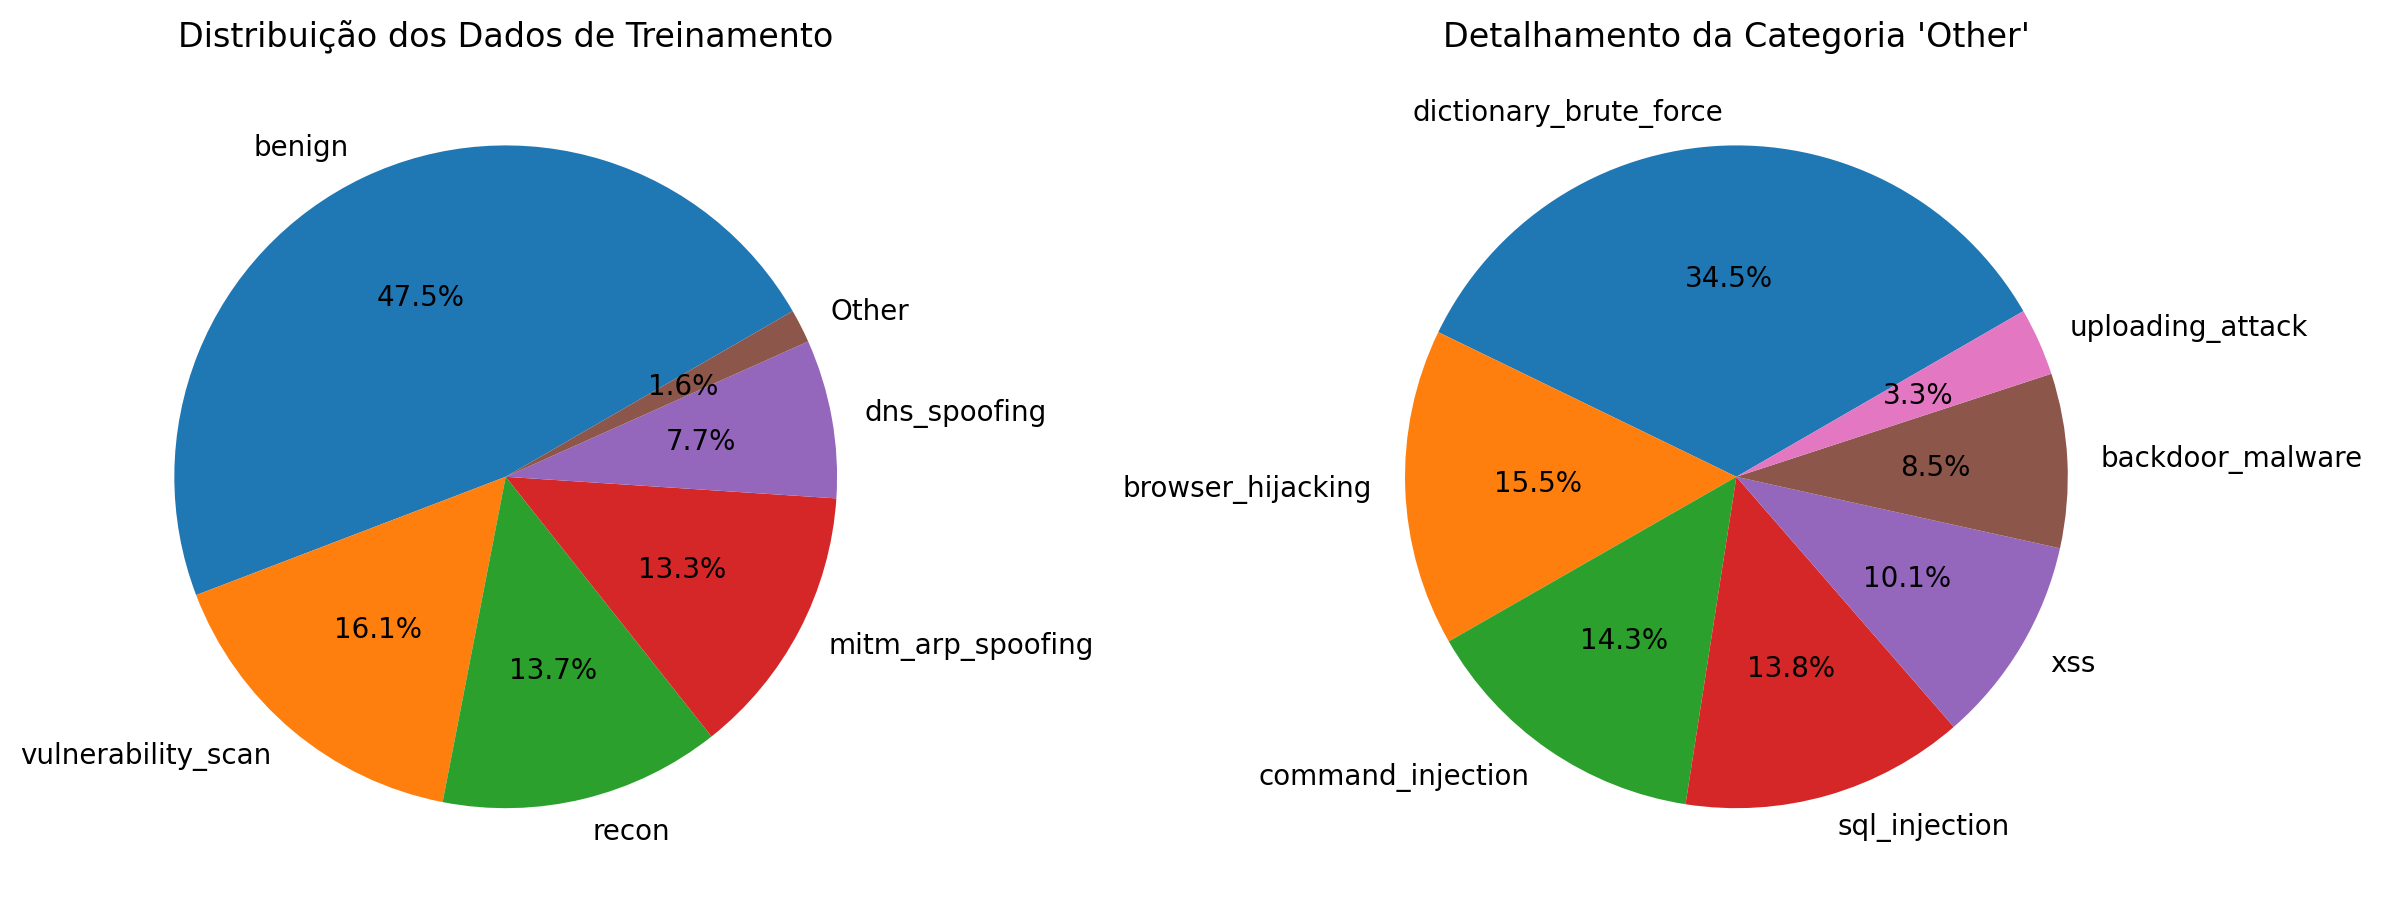

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(filtered, labels=filtered.index, autopct="%1.1f%%", startangle=30)
axes[0].set_title("Distribuição dos Dados de Treinamento")

if "Other" in filtered:
    other_data = data[data < threshold]
    axes[1].pie(other_data, labels=other_data.index, autopct="%1.1f%%", startangle=30)
    axes[1].set_title("Detalhamento da Categoria 'Other'")

plt.tight_layout()
plt.show()

### LabelEncoder

Para alguns modelos, é necessário que as labels sejam números de 0 até a quantidade de classes

In [25]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
target_labels_encoded = list(range(len(label_encoder.classes_)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

## Baseline

### Regressão Logística

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
model_logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
result_logreg = train_model(model_logreg, X_train, X_test, y_train, y_test, target_labels)
results.append(result_logreg)
df_results = pd.DataFrame(results).set_index("model");

In [26]:
joblib.dump(result_logreg, 'models/model_logreg.pkl')

['models/model_logreg.pkl']

In [43]:
df_results[['accuracy', 'precision', 'recall', 'f1', 'train_time', 'test_time']]

accuracy  precision  recall   f1  train_time  \
model                                                                  
LogisticRegression          0.25       0.07    0.12 0.06      539.10   
RandomForestClassifier      0.77       0.59    0.37 0.41      193.31   

                        test_time  
model                              
LogisticRegression           0.35  
RandomForestClassifier      15.39

In [28]:
print(classification_report(y_test, result_logreg['predictions']))

                        precision    recall  f1-score   support

      backdoor_malware       0.00      0.00      0.00       965
                benign       0.68      0.33      0.45    329438
     browser_hijacking       0.00      0.00      0.00      1758
     command_injection       0.00      0.39      0.01      1623
dictionary_brute_force       0.00      0.00      0.00      3919
          dns_spoofing       0.00      0.00      0.00     53668
     mitm_arp_spoofing       0.19      0.68      0.30     92263
                 recon       0.00      0.00      0.00     95153
         sql_injection       0.00      0.00      0.00      1573
      uploading_attack       0.00      0.00      0.00       376
    vulnerability_scan       0.00      0.00      0.00    112003
                   xss       0.00      0.00      0.00      1154

              accuracy                           0.25    693893
             macro avg       0.07      0.12      0.06    693893
          weighted avg       0.35     

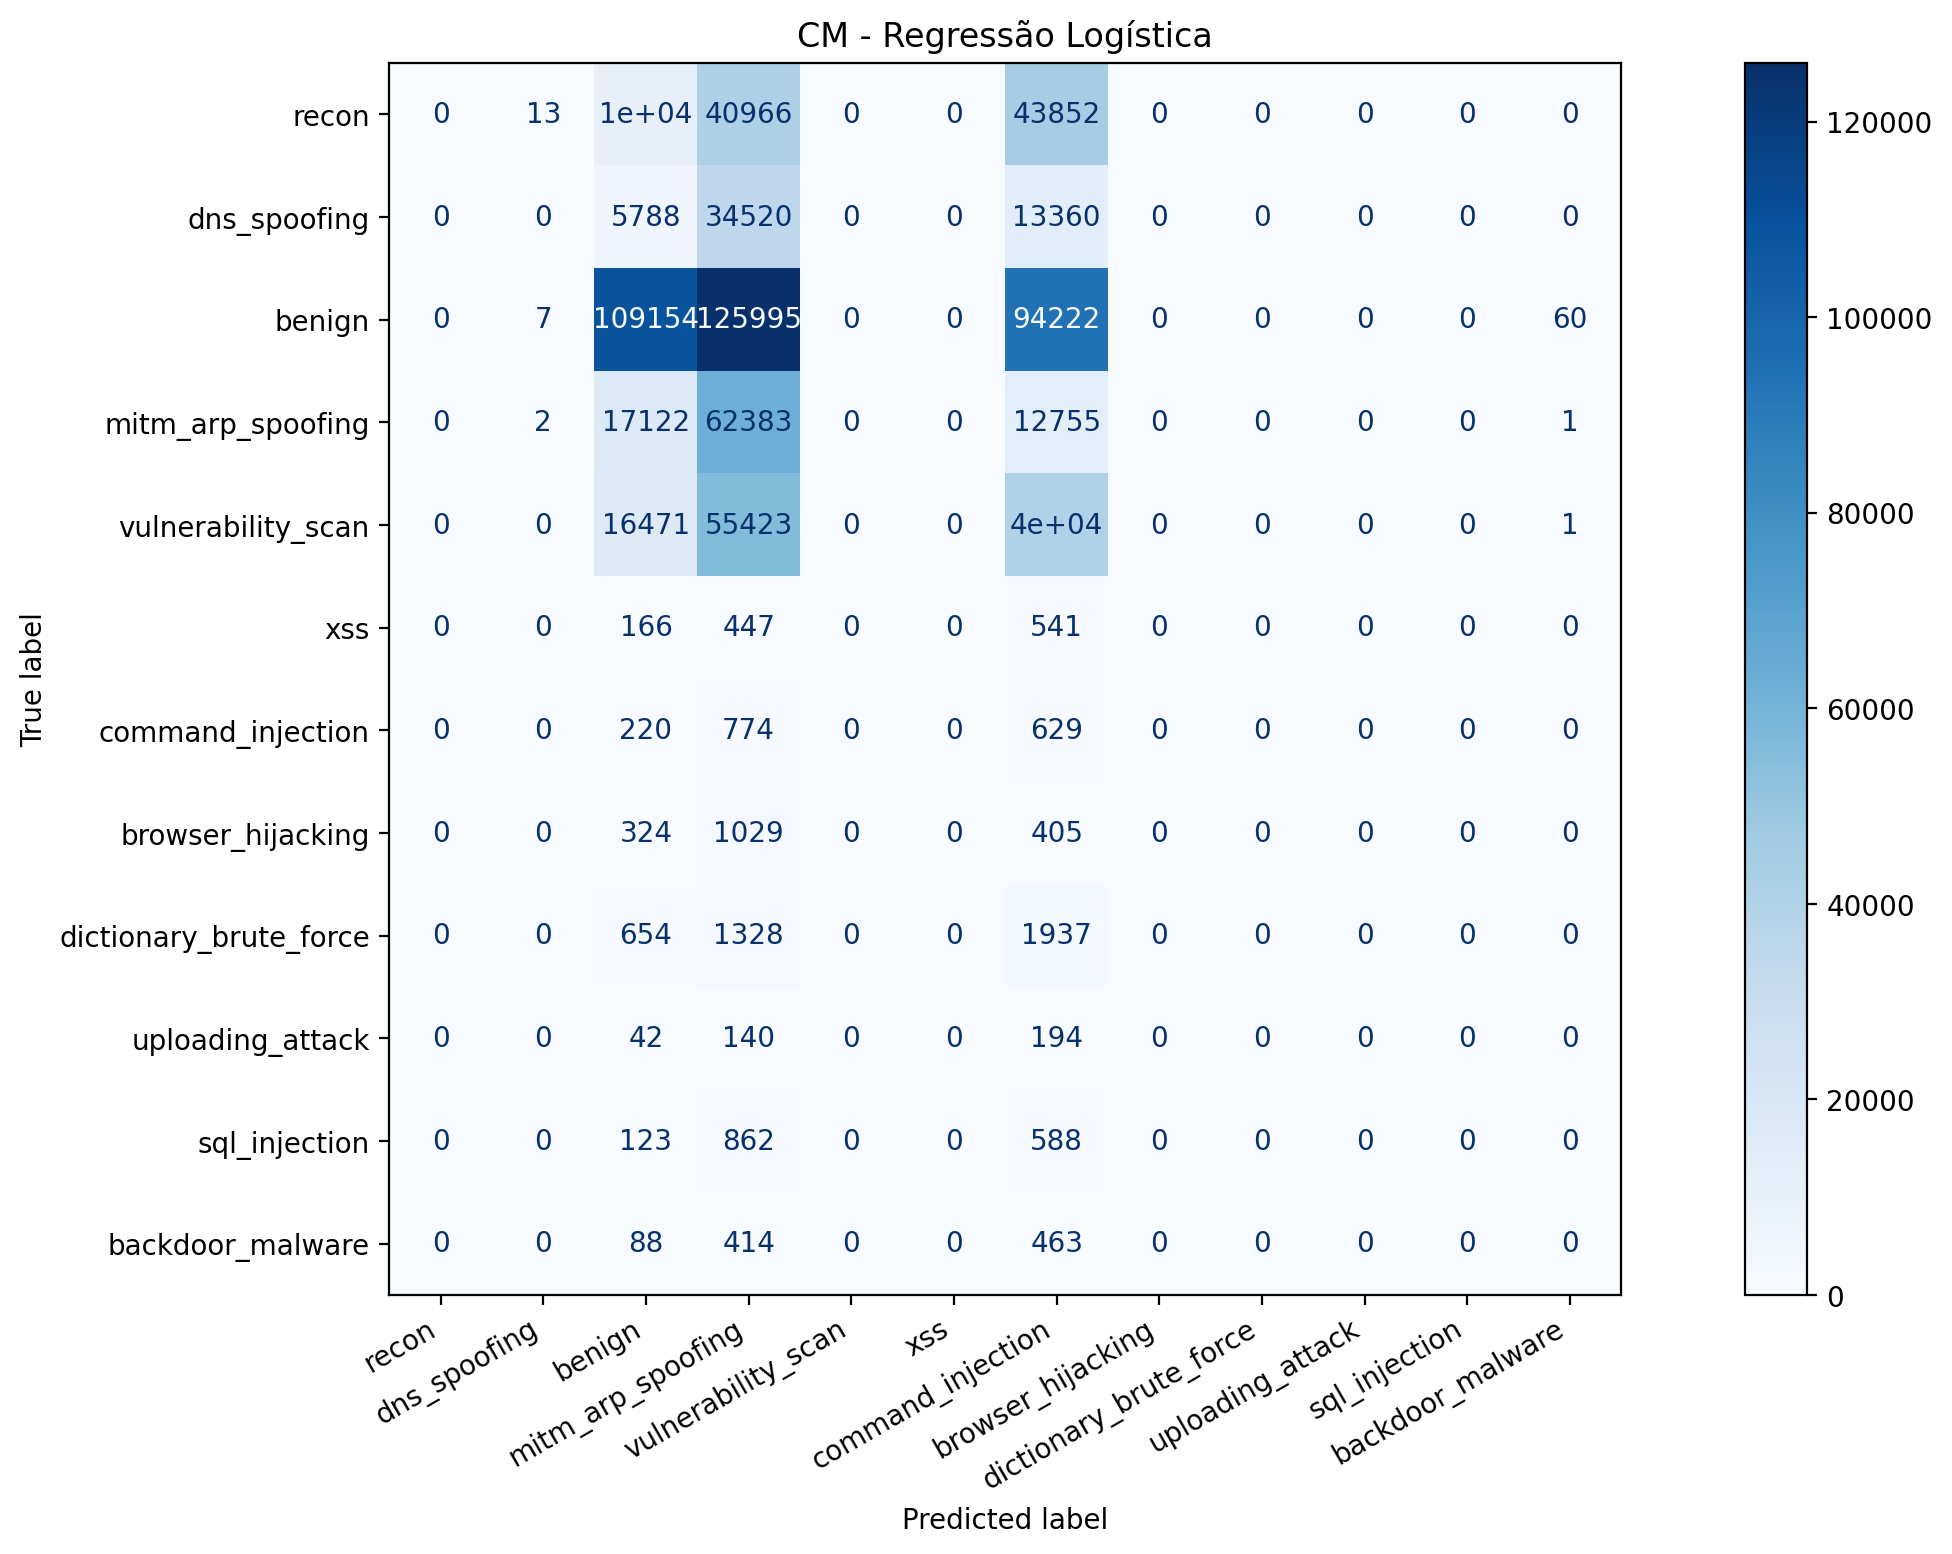

In [29]:
disp = ConfusionMatrixDisplay(df_results.loc['LogisticRegression']['confusion_matrix'], display_labels=target_labels)
fig, ax = plt.subplots(figsize=(16, 8))
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=30, ha="right")
plt.title('CM - Regressão Logística')
plt.show()

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1, max_depth=15)
result_rf = train_model(model_rf, X_train, X_test, y_train, y_test, target_labels)
# results.append(result_rf)
# df_results = pd.DataFrame(results).set_index("model");

{'model': 'RandomForestClassifier',
 'accuracy': 0.6197,
 'precision': 0.3413,
 'recall': 0.4574,
 'f1': 0.323,
 'confusion_matrix': array([[ 44270,    135,  13405,   1678,  11137,   5488,    308,   1984,
           4689,   1634,   8711,   1714],
        [   246,  37664,   2437,   7889,   1176,   1762,    174,    373,
            482,    379,    517,    569],
        [  1803,   2588, 227592,   4133,  33464,  13252,    999,   3970,
          17582,   4680,  15681,   3694],
        [   239,  12861,   7332,  65379,   1306,   1210,    236,    511,
           1102,   1050,    548,    489],
        [  6223,   1748,   7901,   1544,  50455,   6009,    292,   1915,
           5720,   2670,  24948,   2578],
        [    18,      2,    162,     37,    102,    402,     68,     13,
             57,    136,     48,    109],
        [    20,      0,    156,     41,    111,    370,    489,     13,
             56,    198,     47,    122],
        [    30,      8,    225,    135,    150,    203,      3

In [29]:
joblib.dump(result_rf, "models/model_rf.pkl", compress=("zlib", 3))

['models/model_rf.pkl']

In [42]:
df_results[['accuracy', 'precision', 'recall', 'f1', 'train_time', 'test_time']]

accuracy  precision  recall   f1  train_time  \
model                                                                  
LogisticRegression          0.25       0.07    0.12 0.06      539.10   
RandomForestClassifier      0.77       0.59    0.37 0.41      193.31   

                        test_time  
model                              
LogisticRegression           0.35  
RandomForestClassifier      15.39

In [33]:
print(classification_report(y_test, result_rf['predictions']))

                        precision    recall  f1-score   support

      backdoor_malware       0.24      0.05      0.08       965
                benign       0.79      0.92      0.85    329438
     browser_hijacking       0.46      0.26      0.33      1758
     command_injection       0.75      0.24      0.36      1623
dictionary_brute_force       0.82      0.26      0.39      3919
          dns_spoofing       0.80      0.65      0.72     53668
     mitm_arp_spoofing       0.83      0.77      0.80     92263
                 recon       0.78      0.53      0.63     95153
         sql_injection       0.76      0.05      0.10      1573
      uploading_attack       0.00      0.00      0.00       376
    vulnerability_scan       0.64      0.64      0.64    112003
                   xss       0.21      0.02      0.04      1154

              accuracy                           0.77    693893
             macro avg       0.59      0.37      0.41    693893
          weighted avg       0.77     

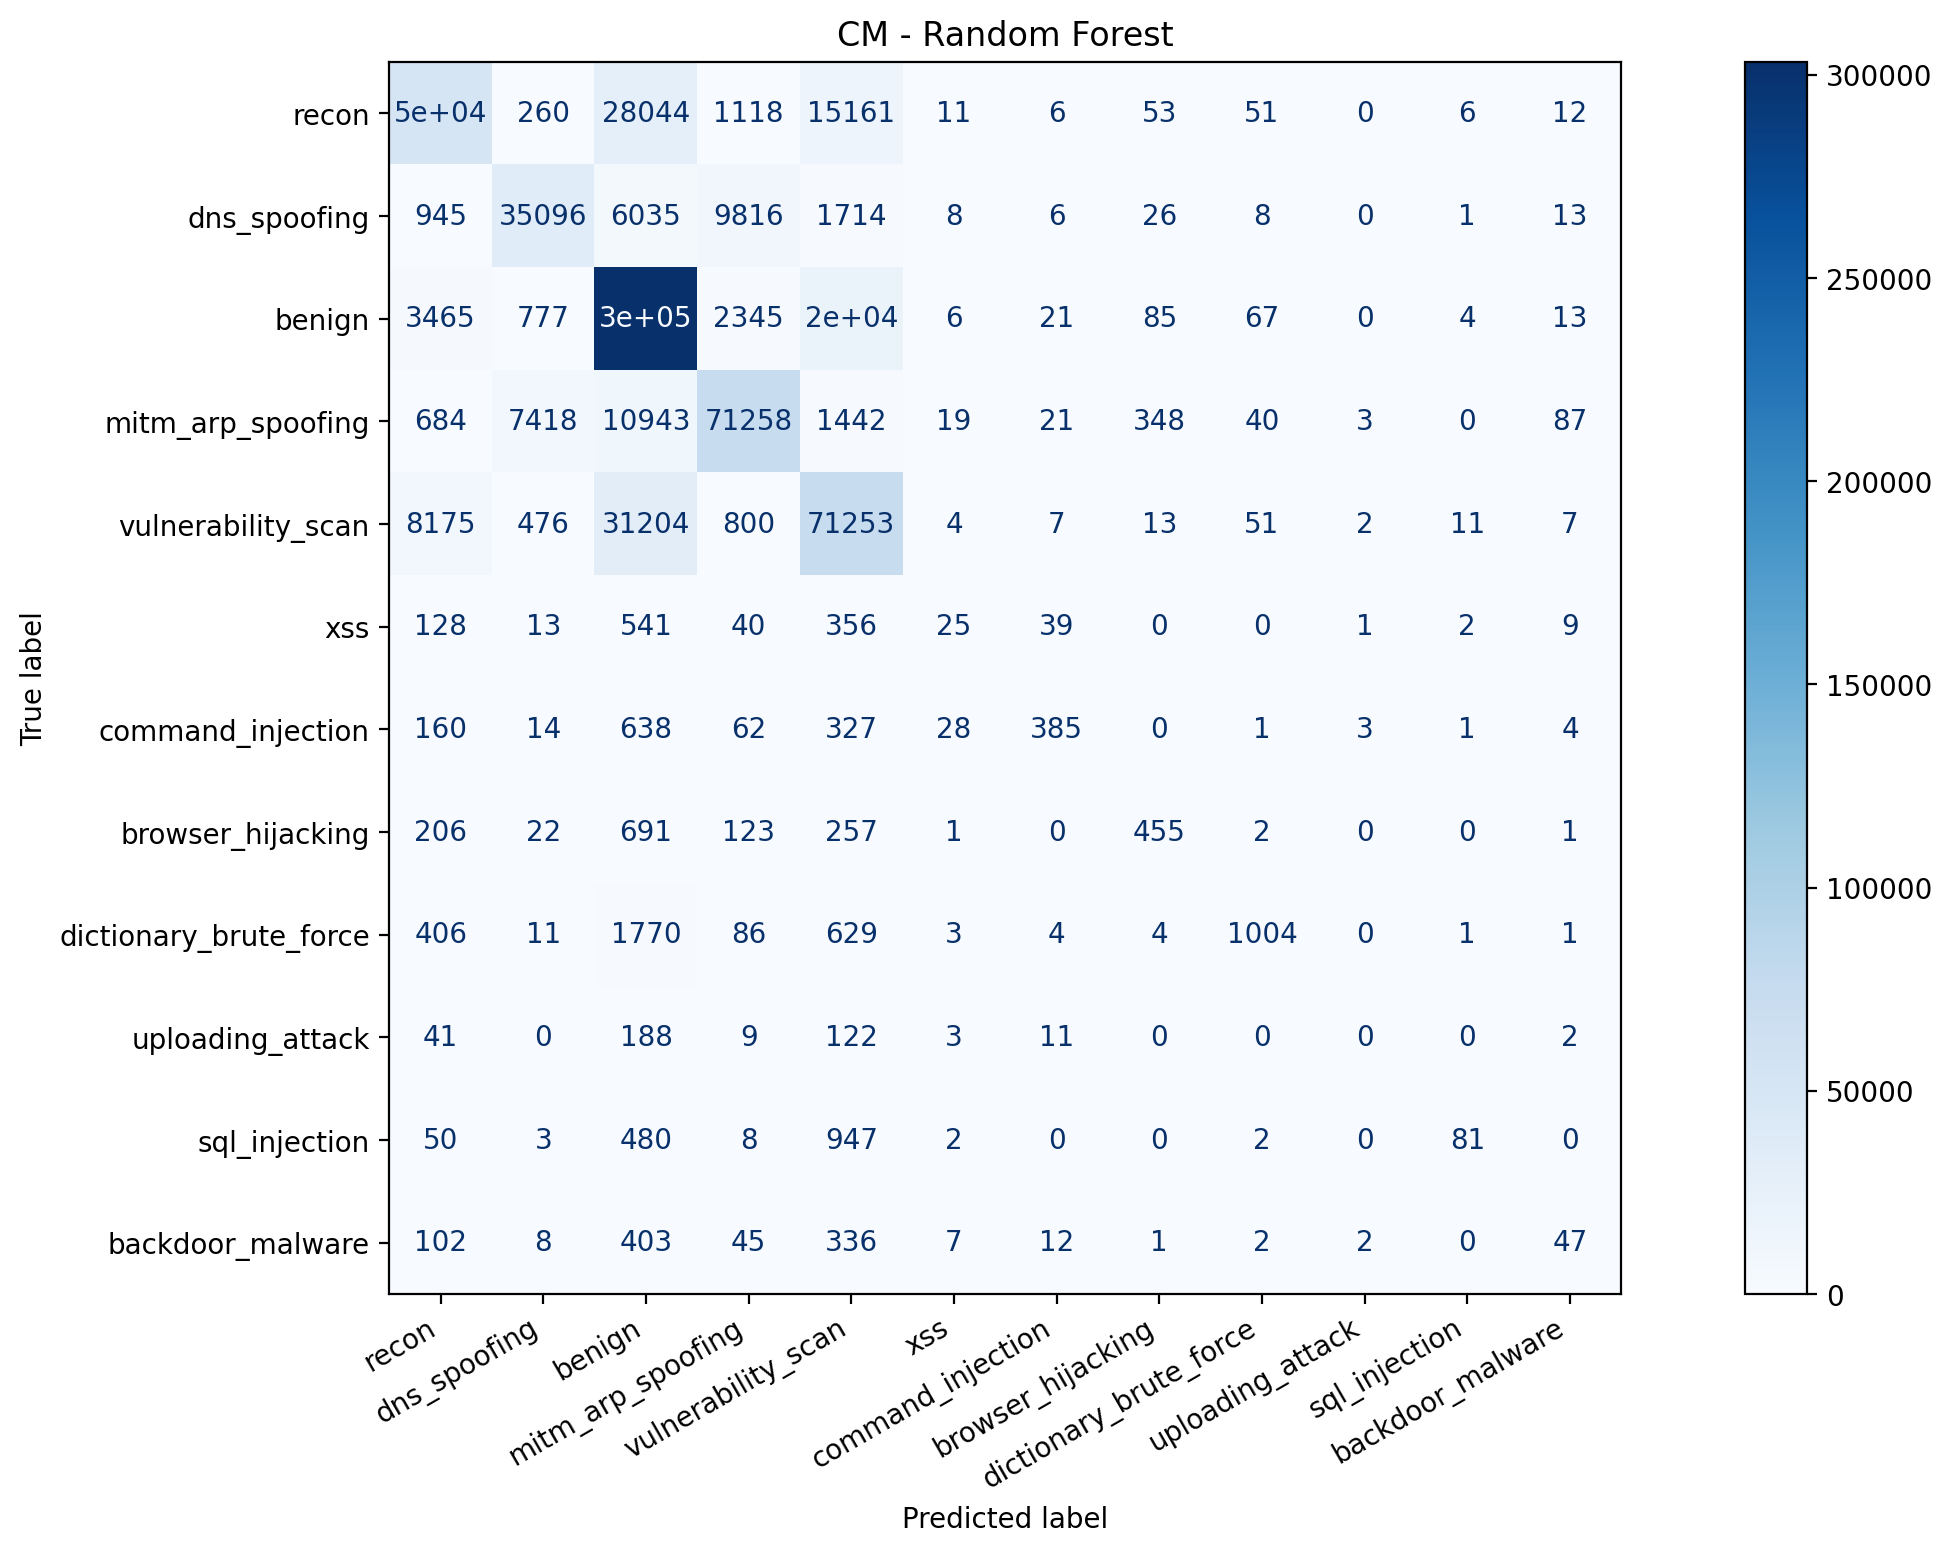

In [34]:
disp = ConfusionMatrixDisplay(df_results.loc['RandomForestClassifier']['confusion_matrix'], display_labels=target_labels)
fig, ax = plt.subplots(figsize=(16, 8))
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=30, ha="right")
plt.title('CM - Random Forest')
plt.show()

---

## Tree-based Ensemble

### XGBoost

In [25]:
from xgboost import XGBClassifier

`scale_pos_weight` = (obervações negativas) / (observações positivas). Com os nossos números: `1,098,126` / `1,214,848` ≈ `0.9`

In [31]:
model_xgb = XGBClassifier(objective='multi:softmax', scale_pos_weight=0.9, # multi-classe, balanceamento
                          n_jobs=-1, tree_method='hist',                   # melhorando a performance
                          random_state=42)                                 # reprodutibilidade
result_xgb = train_model(model_xgb, X_train, X_test, y_train_encoded, y_test_encoded, target_labels_encoded)
results.append(result_xgb)
df_results = pd.DataFrame(results).set_index("model");

In [32]:
joblib.dump(result_xgb, 'models/model_xgb.pkl', compress=3)

['models/model_xgb.pkl']

In [33]:
df_results[['accuracy', 'precision', 'recall', 'f1', 'train_time', 'test_time']]

accuracy  precision  recall   f1  train_time  test_time
model                                                                 
XGBClassifier      0.77       0.67    0.38 0.43      106.21       3.14
XGBClassifier      0.77       0.67    0.38 0.43      102.97       3.05

In [34]:
y_pred_xgb = label_encoder.inverse_transform(result_xgb['predictions'])
print(classification_report(y_test, y_pred_xgb))

                        precision    recall  f1-score   support

      backdoor_malware       0.56      0.08      0.14       965
                benign       0.80      0.92      0.86    329438
     browser_hijacking       0.85      0.31      0.45      1758
     command_injection       0.73      0.26      0.38      1623
dictionary_brute_force       0.88      0.27      0.41      3919
          dns_spoofing       0.80      0.65      0.72     53668
     mitm_arp_spoofing       0.81      0.78      0.80     92263
                 recon       0.79      0.52      0.63     95153
         sql_injection       0.87      0.06      0.11      1573
      uploading_attack       0.00      0.00      0.00       376
    vulnerability_scan       0.63      0.64      0.64    112003
                   xss       0.34      0.04      0.07      1154

              accuracy                           0.77    693893
             macro avg       0.67      0.38      0.43    693893
          weighted avg       0.77     

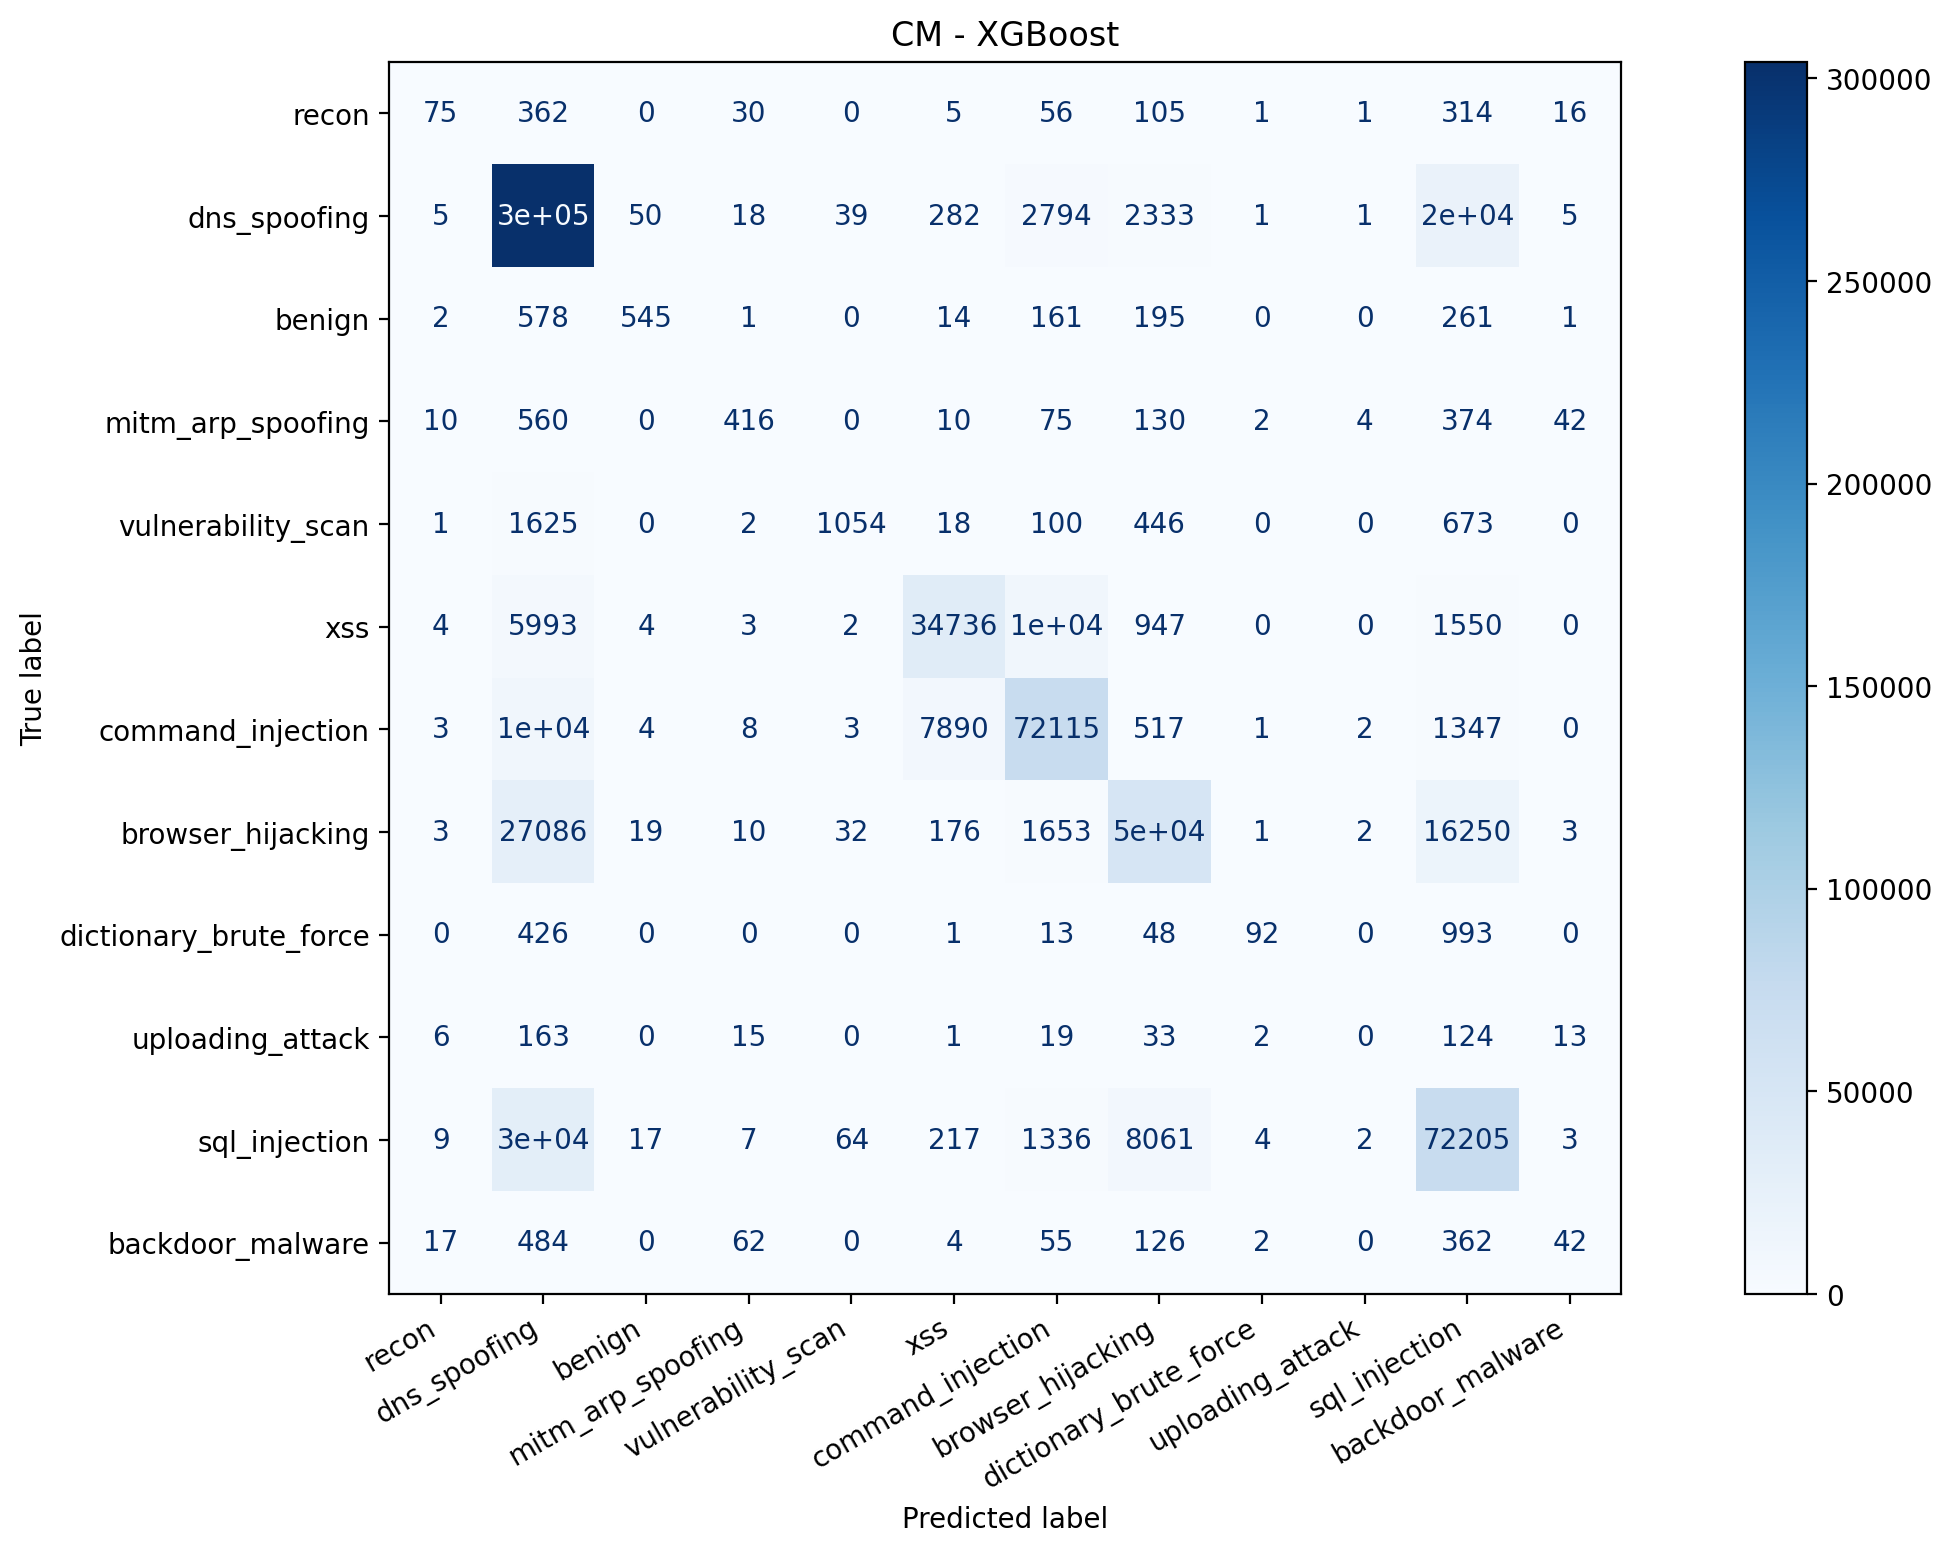

In [48]:
disp = ConfusionMatrixDisplay(df_results.loc['XGBClassifier']['confusion_matrix'], display_labels=target_labels)
fig, ax = plt.subplots(figsize=(16, 8))
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=30, ha="right")
plt.title('CM - XGBoost')
plt.show()

### LightGBM

In [49]:
from lightgbm import LGBMClassifier

In [50]:
model_lgbm = LGBMClassifier(objective='multiclass', n_jobs=-1, random_state=42)
result_lgbm = train_model(model_lgbm, X_train, X_test, y_train_encoded, y_test_encoded, target_labels_encoded)
results.append(result_lgbm)
df_results = pd.DataFrame(results).set_index("model");

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2866
[LightGBM] [Info] Number of data points in the train set: 1619081, number of used features: 42
[LightGBM] [Info] Start training from score -6.577351
[LightGBM] [Info] Start training from score -0.744929
[LightGBM] [Info] Start training from score -5.978383
[LightGBM] [Info] Start training from score -6.058304
[LightGBM] [Info] Start training from score -5.176407
[LightGBM] [Info] Start training from score -2.559502
[LightGBM] [Info] Start training from score -2.017679
[LightGBM] [Info] Start training from score -1.986828
[LightGBM] [Info] Start training from score -6.089150
[LightGBM] [Info] Start training from score -7.522003
[LightGBM] [Info] Start training from score -1.823788
[LightGBM] [Info] Start training from score -6.3993

In [51]:
joblib.dump(result_lgbm, 'models/model_lgbm.pkl', compress=3)

['models/model_lgbm.pkl']

In [58]:
df_results[['accuracy', 'precision', 'recall', 'f1', 'train_time', 'test_time']]

accuracy  precision  recall   f1  train_time  test_time
model                                                                  
XGBClassifier       0.77       0.67    0.38 0.43      106.21       3.14
XGBClassifier       0.77       0.67    0.38 0.43      102.97       3.05
LGBMClassifier      0.76       0.47    0.37 0.40       55.14      10.11

In [53]:
print(classification_report(y_test, label_encoder.inverse_transform(result_lgbm['predictions'])))

                        precision    recall  f1-score   support

      backdoor_malware       0.13      0.08      0.10       965
                benign       0.79      0.91      0.85    329438
     browser_hijacking       0.51      0.26      0.35      1758
     command_injection       0.33      0.22      0.27      1623
dictionary_brute_force       0.63      0.28      0.38      3919
          dns_spoofing       0.77      0.64      0.70     53668
     mitm_arp_spoofing       0.81      0.75      0.78     92263
                 recon       0.79      0.50      0.62     95153
         sql_injection       0.16      0.06      0.08      1573
      uploading_attack       0.01      0.01      0.01       376
    vulnerability_scan       0.62      0.63      0.62    112003
                   xss       0.06      0.03      0.04      1154

              accuracy                           0.76    693893
             macro avg       0.47      0.37      0.40    693893
          weighted avg       0.75     

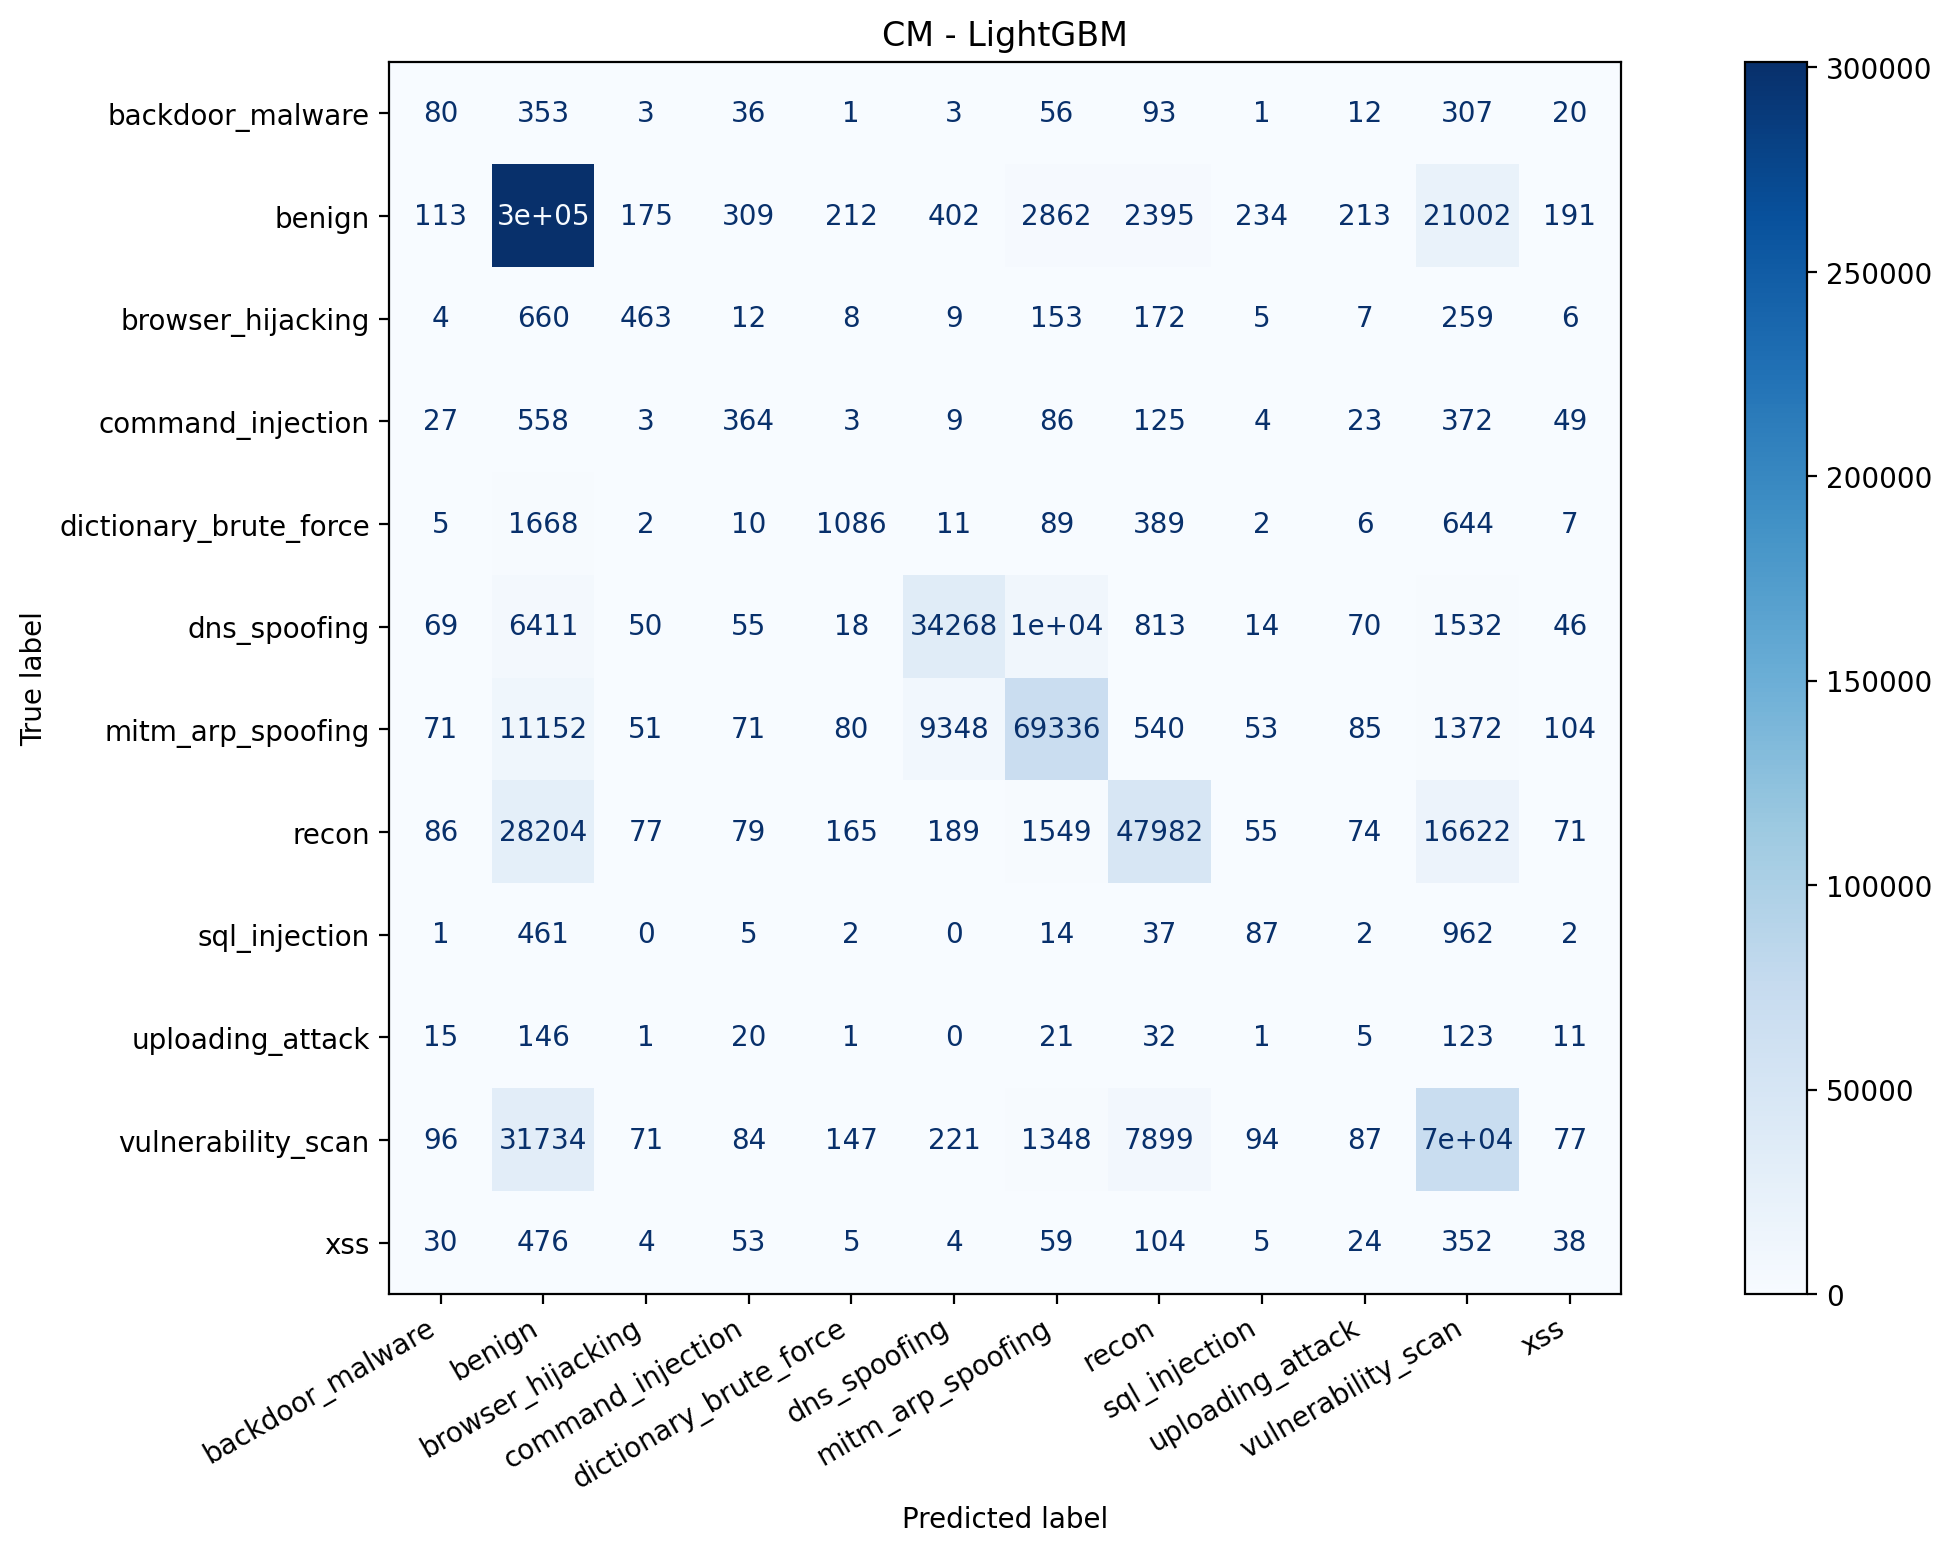

In [59]:
disp = ConfusionMatrixDisplay(df_results.loc['LGBMClassifier']['confusion_matrix'], display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(16, 8))
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=30, ha="right")
plt.title('CM - LightGBM')
plt.show()

---

## Redes Neurais

### MLP

In [77]:
from sklearn.neural_network import MLPClassifier

In [78]:
model_mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=200, random_state=42)
result_mlp = train_model(model_mlp, X_train, X_test, y_train_encoded, y_test_encoded, target_labels_encoded)
results.append(result_mlp)
df_results = pd.DataFrame(results).set_index("model");

{'model': 'MLPClassifier',
 'accuracy': 0.5111,
 'precision': 0.1533,
 'recall': 0.1084,
 'f1': 0.0882,
 'confusion_matrix': array([[     0,    754,      0,      0,      0,      0,      0,      0,
              0,      0,    211,      0],
        [     0, 316928,      0,      0,      0,      0,      0,      0,
              0,      0,  12510,      0],
        [     0,   1619,      0,      0,      0,      0,      0,      0,
              0,      0,    139,      0],
        [     0,   1378,      0,      0,      0,      0,      0,      0,
              0,      0,    245,      0],
        [     0,   3040,      0,      0,      0,      0,      0,      0,
              0,      0,    879,      0],
        [     0,  51410,      0,      0,      0,      0,      0,      0,
              0,      0,   2258,      0],
        [     0,  90281,      0,      0,      0,      0,      0,      0,
              0,      0,   1982,      0],
        [     0,  53445,      0,      0,      0,      0,      0,   1071

In [79]:
joblib.dump(result_mlp, 'models/model_mlp.pkl', compress=3)

['models/model_mlp.pkl']

In [80]:
df_results[['accuracy', 'precision', 'recall', 'f1', 'train_time', 'test_time']]

accuracy  precision  recall   f1  train_time  test_time
model                                                                    
XGBClassifier         0.77       0.67    0.38 0.43      106.21       3.14
XGBClassifier         0.77       0.67    0.38 0.43      102.97       3.05
LGBMClassifier        0.76       0.47    0.37 0.40       55.14      10.11
MLPClassifier         0.51       0.15    0.11 0.09      227.56       7.21
TabNetClassifier      0.72       0.57    0.32 0.35    4,285.87       7.79

In [81]:
y_pred_mlp = label_encoder.inverse_transform(result_mlp['predictions'])
print(classification_report(y_test, y_pred_mlp))

                        precision    recall  f1-score   support

      backdoor_malware       0.00      0.00      0.00       965
                benign       0.53      0.96      0.68    329438
     browser_hijacking       0.00      0.00      0.00      1758
     command_injection       0.00      0.00      0.00      1623
dictionary_brute_force       0.00      0.00      0.00      3919
          dns_spoofing       0.00      0.00      0.00     53668
     mitm_arp_spoofing       0.00      0.00      0.00     92263
                 recon       0.93      0.01      0.02     95153
         sql_injection       0.00      0.00      0.00      1573
      uploading_attack       0.00      0.00      0.00       376
    vulnerability_scan       0.38      0.33      0.35    112003
                   xss       0.00      0.00      0.00      1154

              accuracy                           0.51    693893
             macro avg       0.15      0.11      0.09    693893
          weighted avg       0.44     

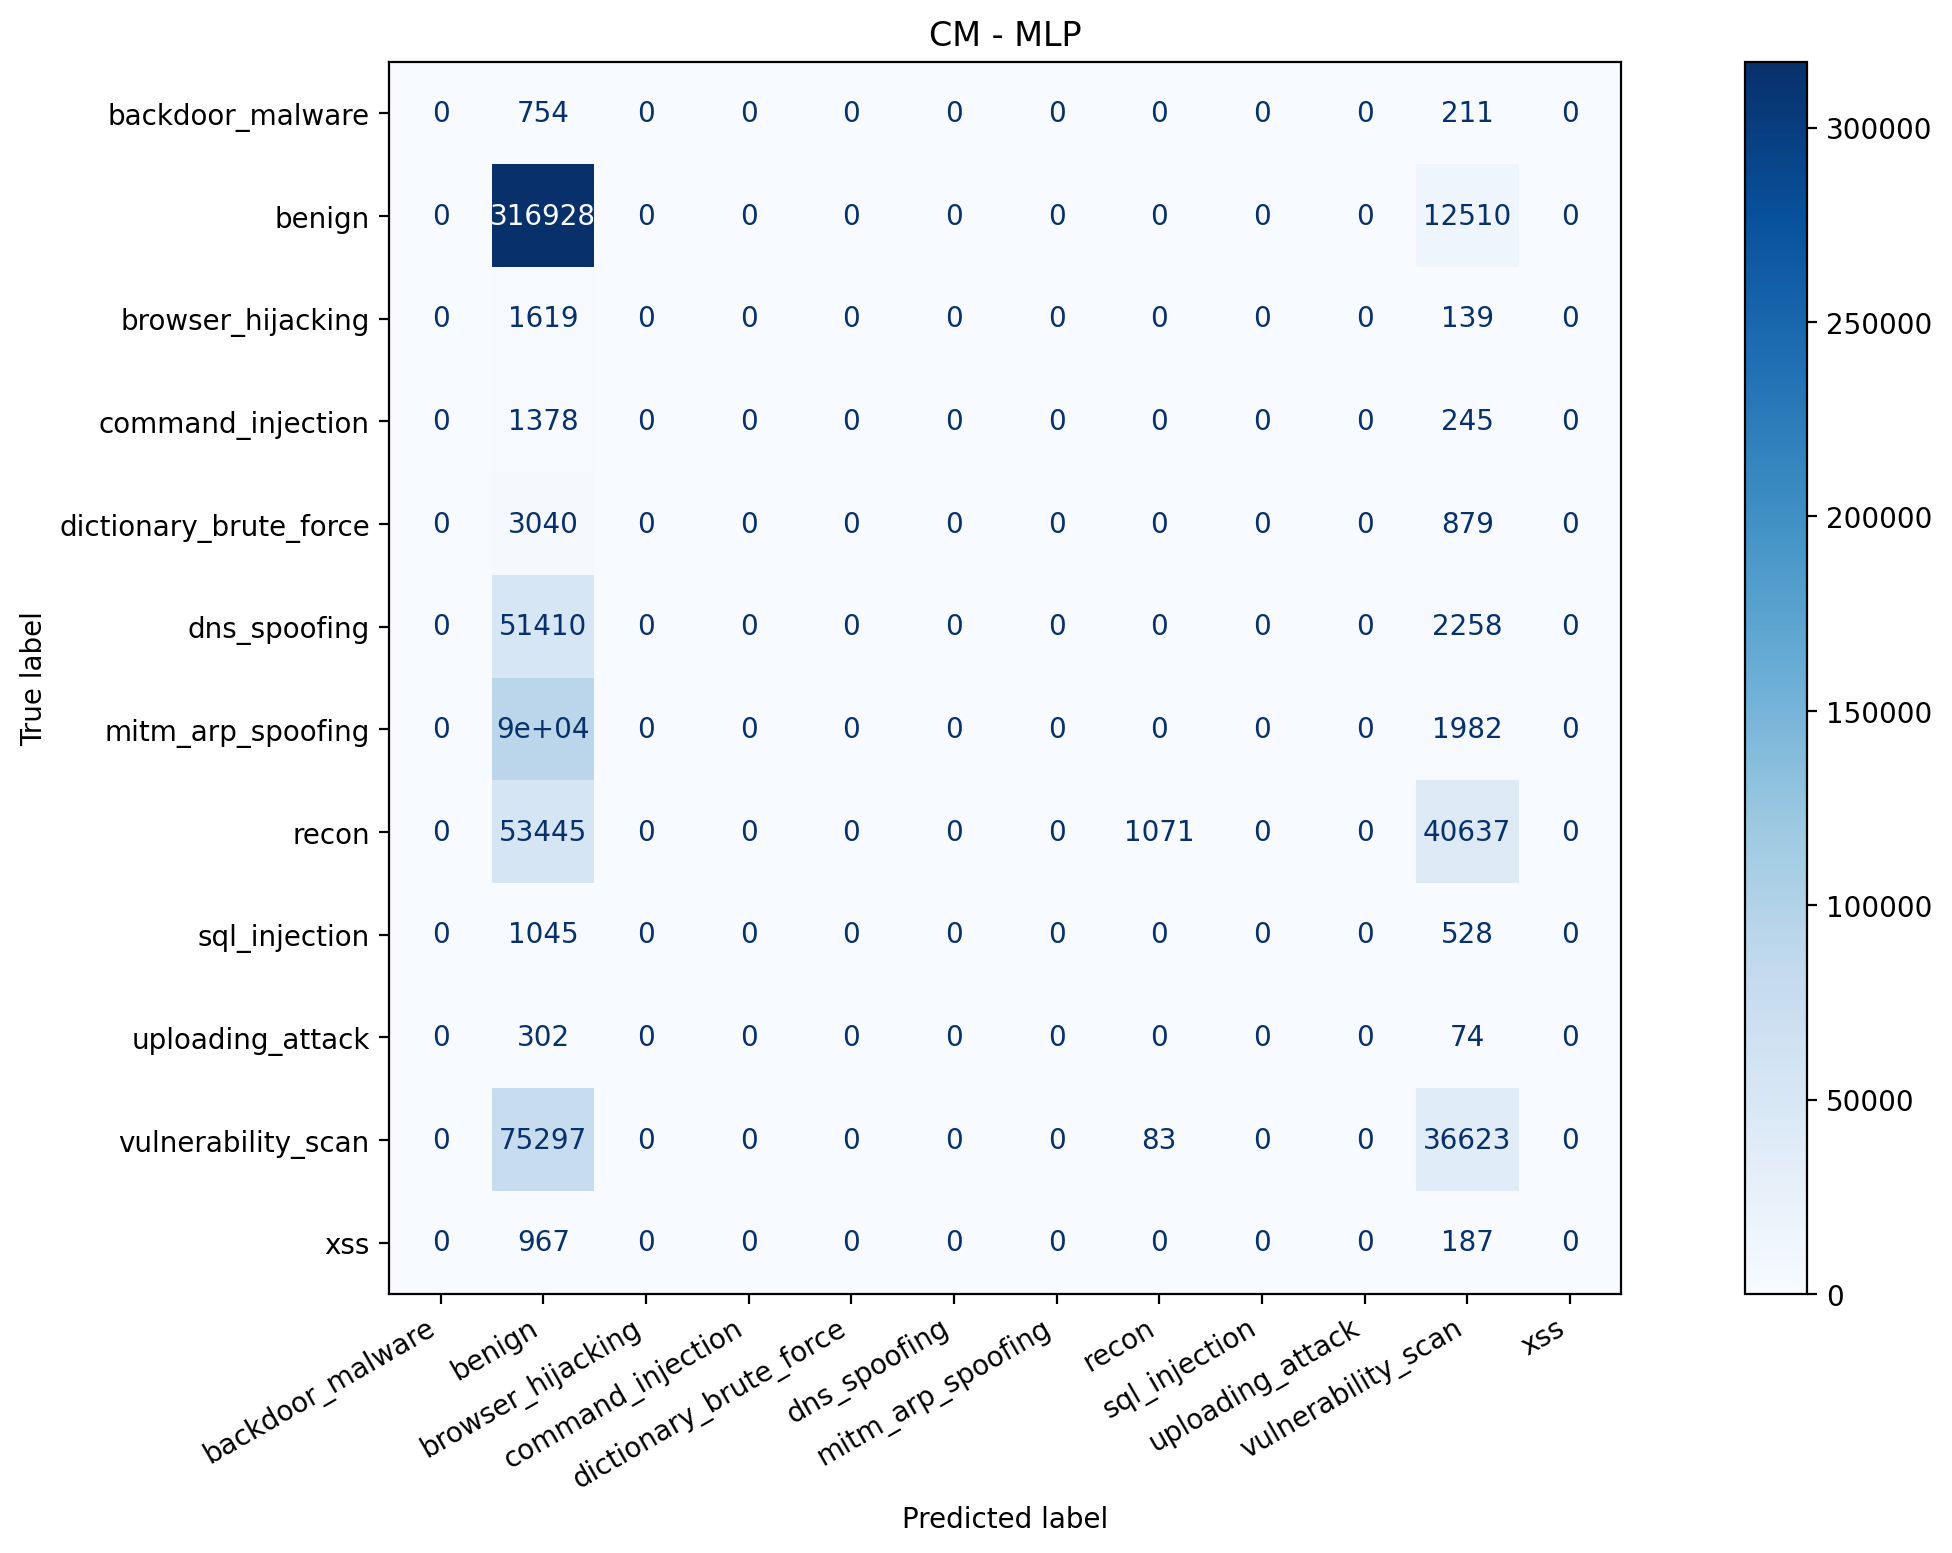

In [82]:
disp = ConfusionMatrixDisplay(confusion_matrix=result_mlp['confusion_matrix'], display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(16, 8))
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=30, ha="right")
plt.title('CM - MLP')
plt.show()

### CNN (TabNet)

Utilizaremos o modelo TabNet conforme descrito no artigo "TabNet: Attentive Interpretable Tabular Learning" (Arik & Pfister, 2020). Este modelo foi desenvolvido especificamente para dados tabulares, combinando mecanismos de atenção para selecionar dinamicamente as features mais relevantes em cada etapa do processo de decisão. Dado que os dados de tráfego de rede utilizados neste trabalho são tabulares e exigem uma abordagem relativamente simples, porém eficaz e interpretável, o TabNet se apresenta como uma escolha apropriada para alcançar um bom desempenho sem complexidades excessivas na modelagem.

> Por ser uma rede, possui diversos hiperparâmetros que poderiam ser ajustados

Esquemático da arquitetura:

![TabNet](images/tabnet.webp)

In [70]:
from pytorch_tabnet.tab_model import TabNetClassifier

In [71]:
model_tabnet = TabNetClassifier()
result_tabnet = train_model(model_tabnet, X_train, X_test, y_train_encoded, y_test_encoded, target_labels_encoded)
results.append(result_tabnet)
df_results = pd.DataFrame(results).set_index("model");

epoch 0  | loss: 0.94183 |  0:00:39s
epoch 1  | loss: 0.81416 |  0:01:19s
epoch 2  | loss: 0.78102 |  0:01:59s
epoch 3  | loss: 0.76572 |  0:02:39s
epoch 4  | loss: 0.75919 |  0:03:18s
epoch 5  | loss: 0.75234 |  0:03:58s
epoch 6  | loss: 0.74938 |  0:04:38s
epoch 7  | loss: 0.74626 |  0:05:18s
epoch 8  | loss: 0.74429 |  0:05:57s
epoch 9  | loss: 0.74365 |  0:06:37s
epoch 10 | loss: 0.74059 |  0:07:16s
epoch 11 | loss: 0.73895 |  0:07:56s
epoch 12 | loss: 0.74031 |  0:08:36s
epoch 13 | loss: 0.73989 |  0:09:15s
epoch 14 | loss: 0.74716 |  0:09:55s
epoch 15 | loss: 0.7376  |  0:10:35s
epoch 16 | loss: 0.73542 |  0:11:14s
epoch 17 | loss: 0.73502 |  0:11:54s
epoch 18 | loss: 0.73181 |  0:12:33s
epoch 19 | loss: 0.73494 |  0:13:13s
epoch 20 | loss: 0.73182 |  0:13:52s
epoch 21 | loss: 0.72964 |  0:14:32s
epoch 22 | loss: 0.73421 |  0:15:11s
epoch 23 | loss: 0.73133 |  0:15:51s
epoch 24 | loss: 0.72947 |  0:16:30s
epoch 25 | loss: 0.72961 |  0:17:09s
epoch 26 | loss: 0.72771 |  0:17:49s
e

In [75]:
joblib.dump(result_tabnet, 'models/model_tabnet.pkl', compress=3)

['models/model_tabnet.pkl']

In [76]:
df_results[['accuracy', 'precision', 'recall', 'f1', 'train_time', 'test_time']]

accuracy  precision  recall   f1  train_time  test_time
model                                                                    
XGBClassifier         0.77       0.67    0.38 0.43      106.21       3.14
XGBClassifier         0.77       0.67    0.38 0.43      102.97       3.05
LGBMClassifier        0.76       0.47    0.37 0.40       55.14      10.11
MLPClassifier         0.51       0.15    0.11 0.09      227.56       7.21
TabNetClassifier      0.72       0.57    0.32 0.35    4,285.87       7.79

In [102]:
y_pred_tabnet = label_encoder.inverse_transform(result_tabnet['predictions'])
print(classification_report(y_test, y_pred_tabnet))

                        precision    recall  f1-score   support

      backdoor_malware       0.00      0.00      0.00       965
                benign       0.78      0.88      0.82    329438
     browser_hijacking       0.86      0.08      0.15      1758
     command_injection       0.61      0.25      0.36      1623
dictionary_brute_force       0.77      0.22      0.34      3919
          dns_spoofing       0.68      0.63      0.65     53668
     mitm_arp_spoofing       0.80      0.59      0.67     92263
                 recon       0.86      0.44      0.58     95153
         sql_injection       0.92      0.01      0.02      1573
      uploading_attack       0.00      0.00      0.00       376
    vulnerability_scan       0.52      0.72      0.61    112003
                   xss       0.00      0.00      0.00      1154

              accuracy                           0.72    693893
             macro avg       0.57      0.32      0.35    693893
          weighted avg       0.74     

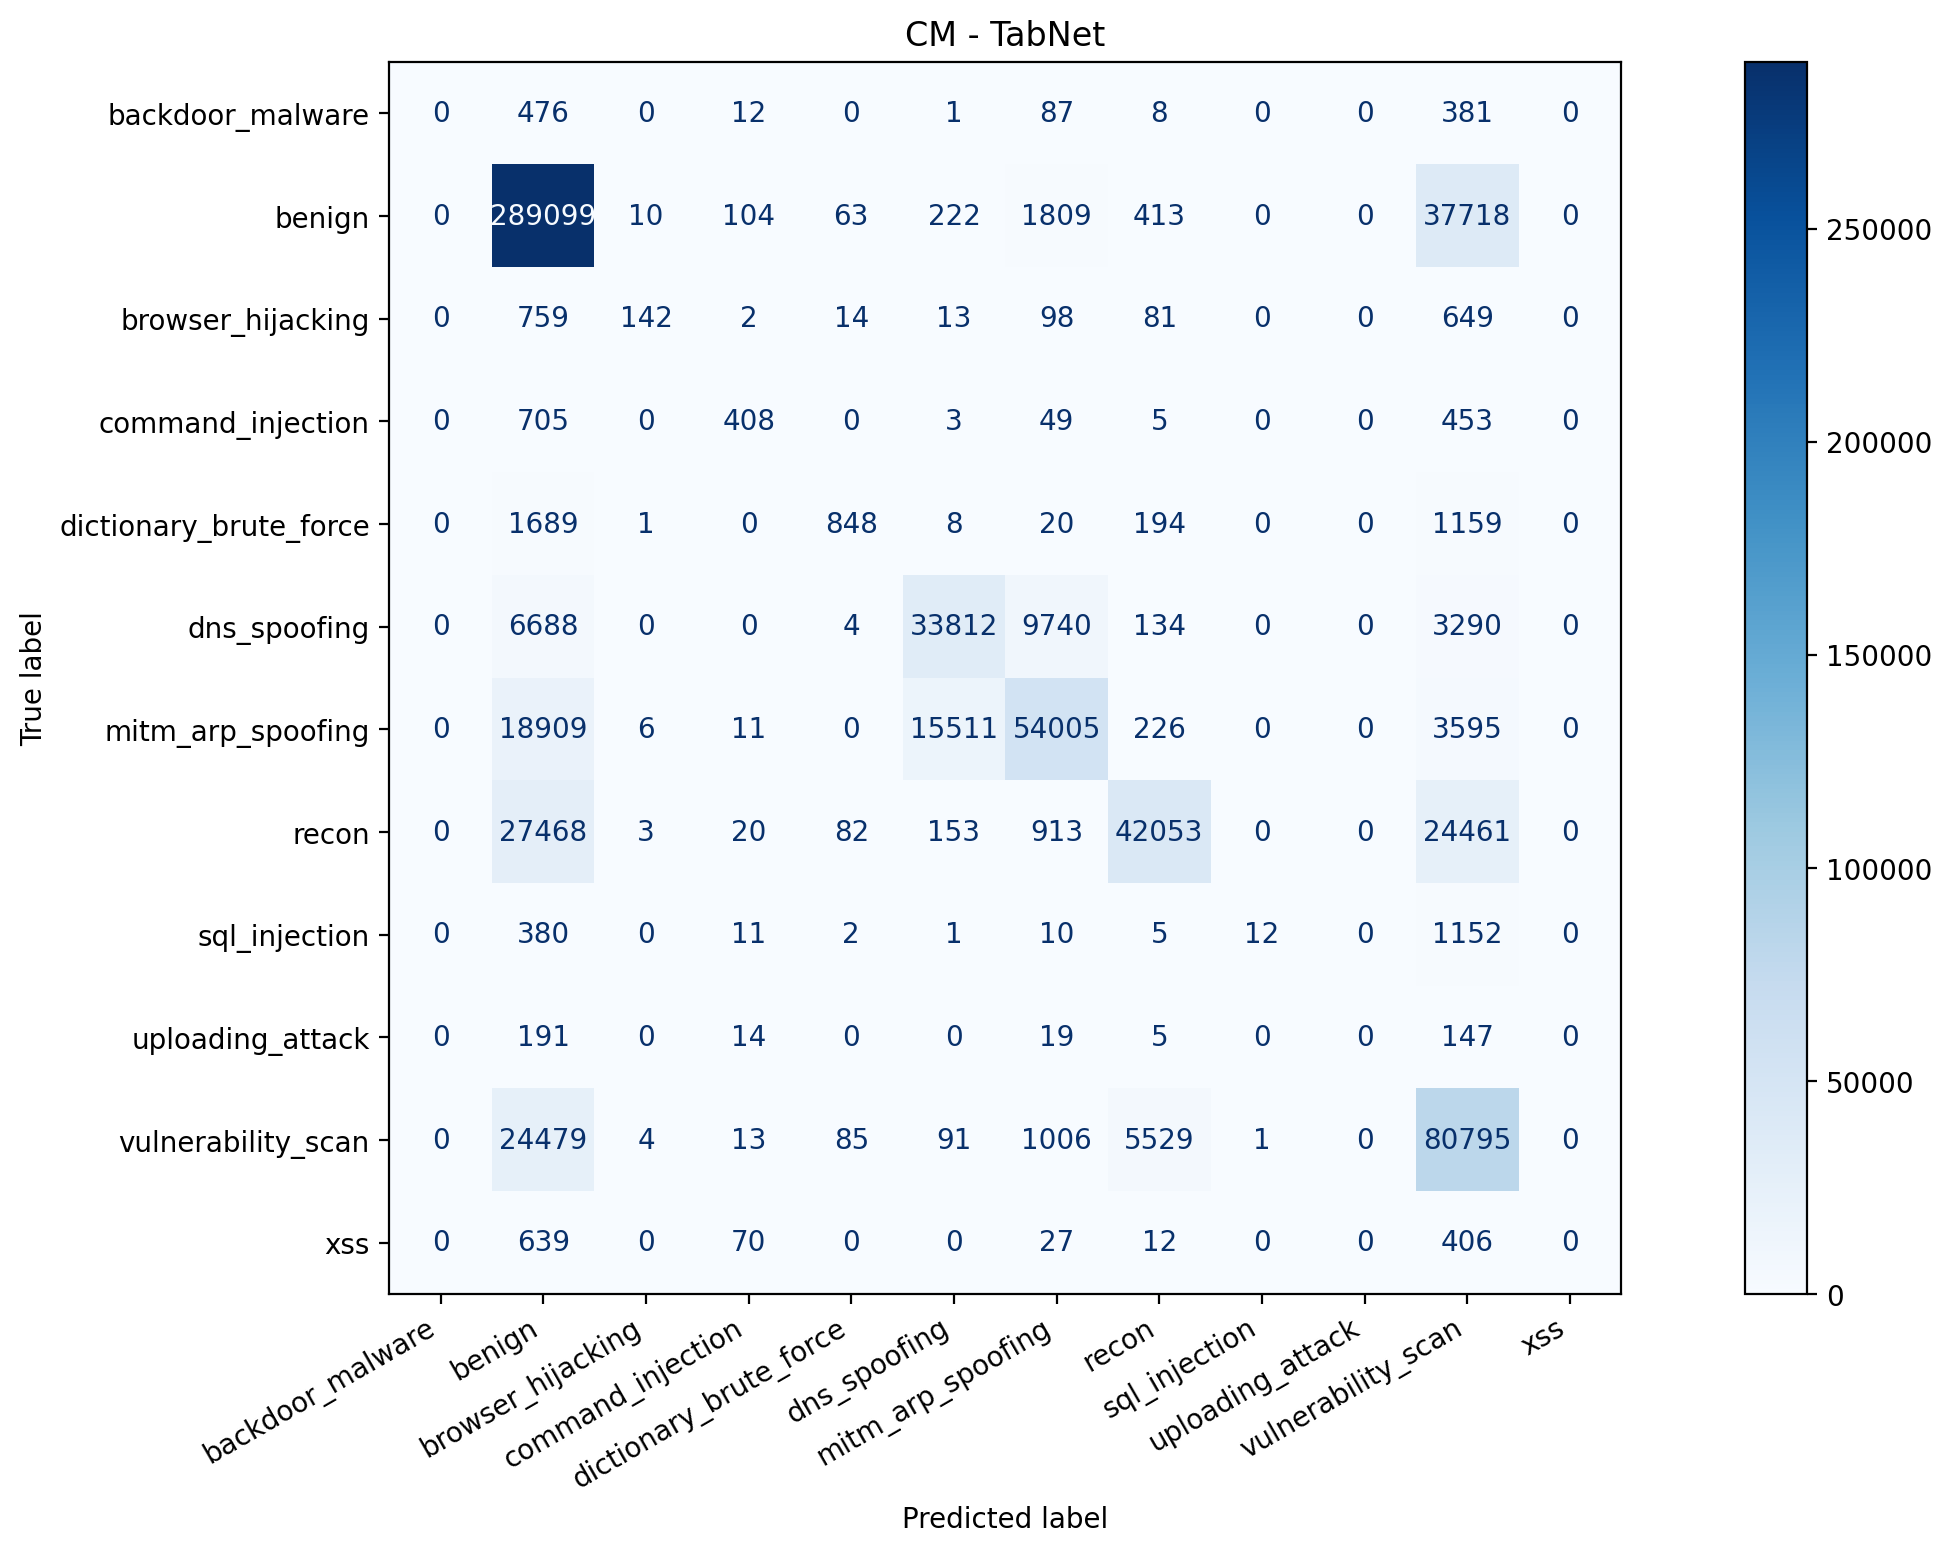

In [104]:
disp = ConfusionMatrixDisplay(confusion_matrix=result_tabnet['confusion_matrix'], display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(16, 8))
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=30, ha="right")
plt.title('CM - TabNet')
plt.show()

---

## Kernel-based

### SVM (RBF Kernel)

O uso de *Radial Basis Function* dá-se pela não-linearidade das variáveis (observável no PCA anteriormente feito)

In [64]:
from sklearn.svm import LinearSVC

In [65]:
model_svm = LinearSVC(class_weight='balanced', max_iter=5000, tol=1e-4, random_state=42)
result_svm = train_model(model_svm, X_train, X_test, y_train_encoded, y_test_encoded, target_labels_encoded)
results.append(result_svm)
df_results = pd.DataFrame(results).set_index("model");

In [66]:
joblib.dump(result_svm, 'models/model_svm.pkl', compress=3)

['models/model_svm.pkl']

In [67]:
df_results[['accuracy', 'precision', 'recall', 'f1', 'train_time', 'test_time']]

accuracy  precision  recall   f1  train_time  test_time
model                                                             
LinearSVC      0.36       0.17    0.19 0.14      871.56       0.34

In [68]:
y_pred_svm = label_encoder.inverse_transform(result_svm['predictions'])
print(classification_report(y_test, y_pred_svm))

                        precision    recall  f1-score   support

      backdoor_malware       0.00      0.01      0.00       965
                benign       0.65      0.52      0.57    329438
     browser_hijacking       0.02      0.04      0.02      1758
     command_injection       0.01      0.19      0.02      1623
dictionary_brute_force       0.01      0.05      0.02      3919
          dns_spoofing       0.17      0.15      0.16     53668
     mitm_arp_spoofing       0.45      0.17      0.25     92263
                 recon       0.38      0.32      0.34     95153
         sql_injection       0.01      0.18      0.02      1573
      uploading_attack       0.00      0.46      0.00       376
    vulnerability_scan       0.33      0.22      0.26    112003
                   xss       0.00      0.01      0.00      1154

              accuracy                           0.36    693893
             macro avg       0.17      0.19      0.14    693893
          weighted avg       0.48     

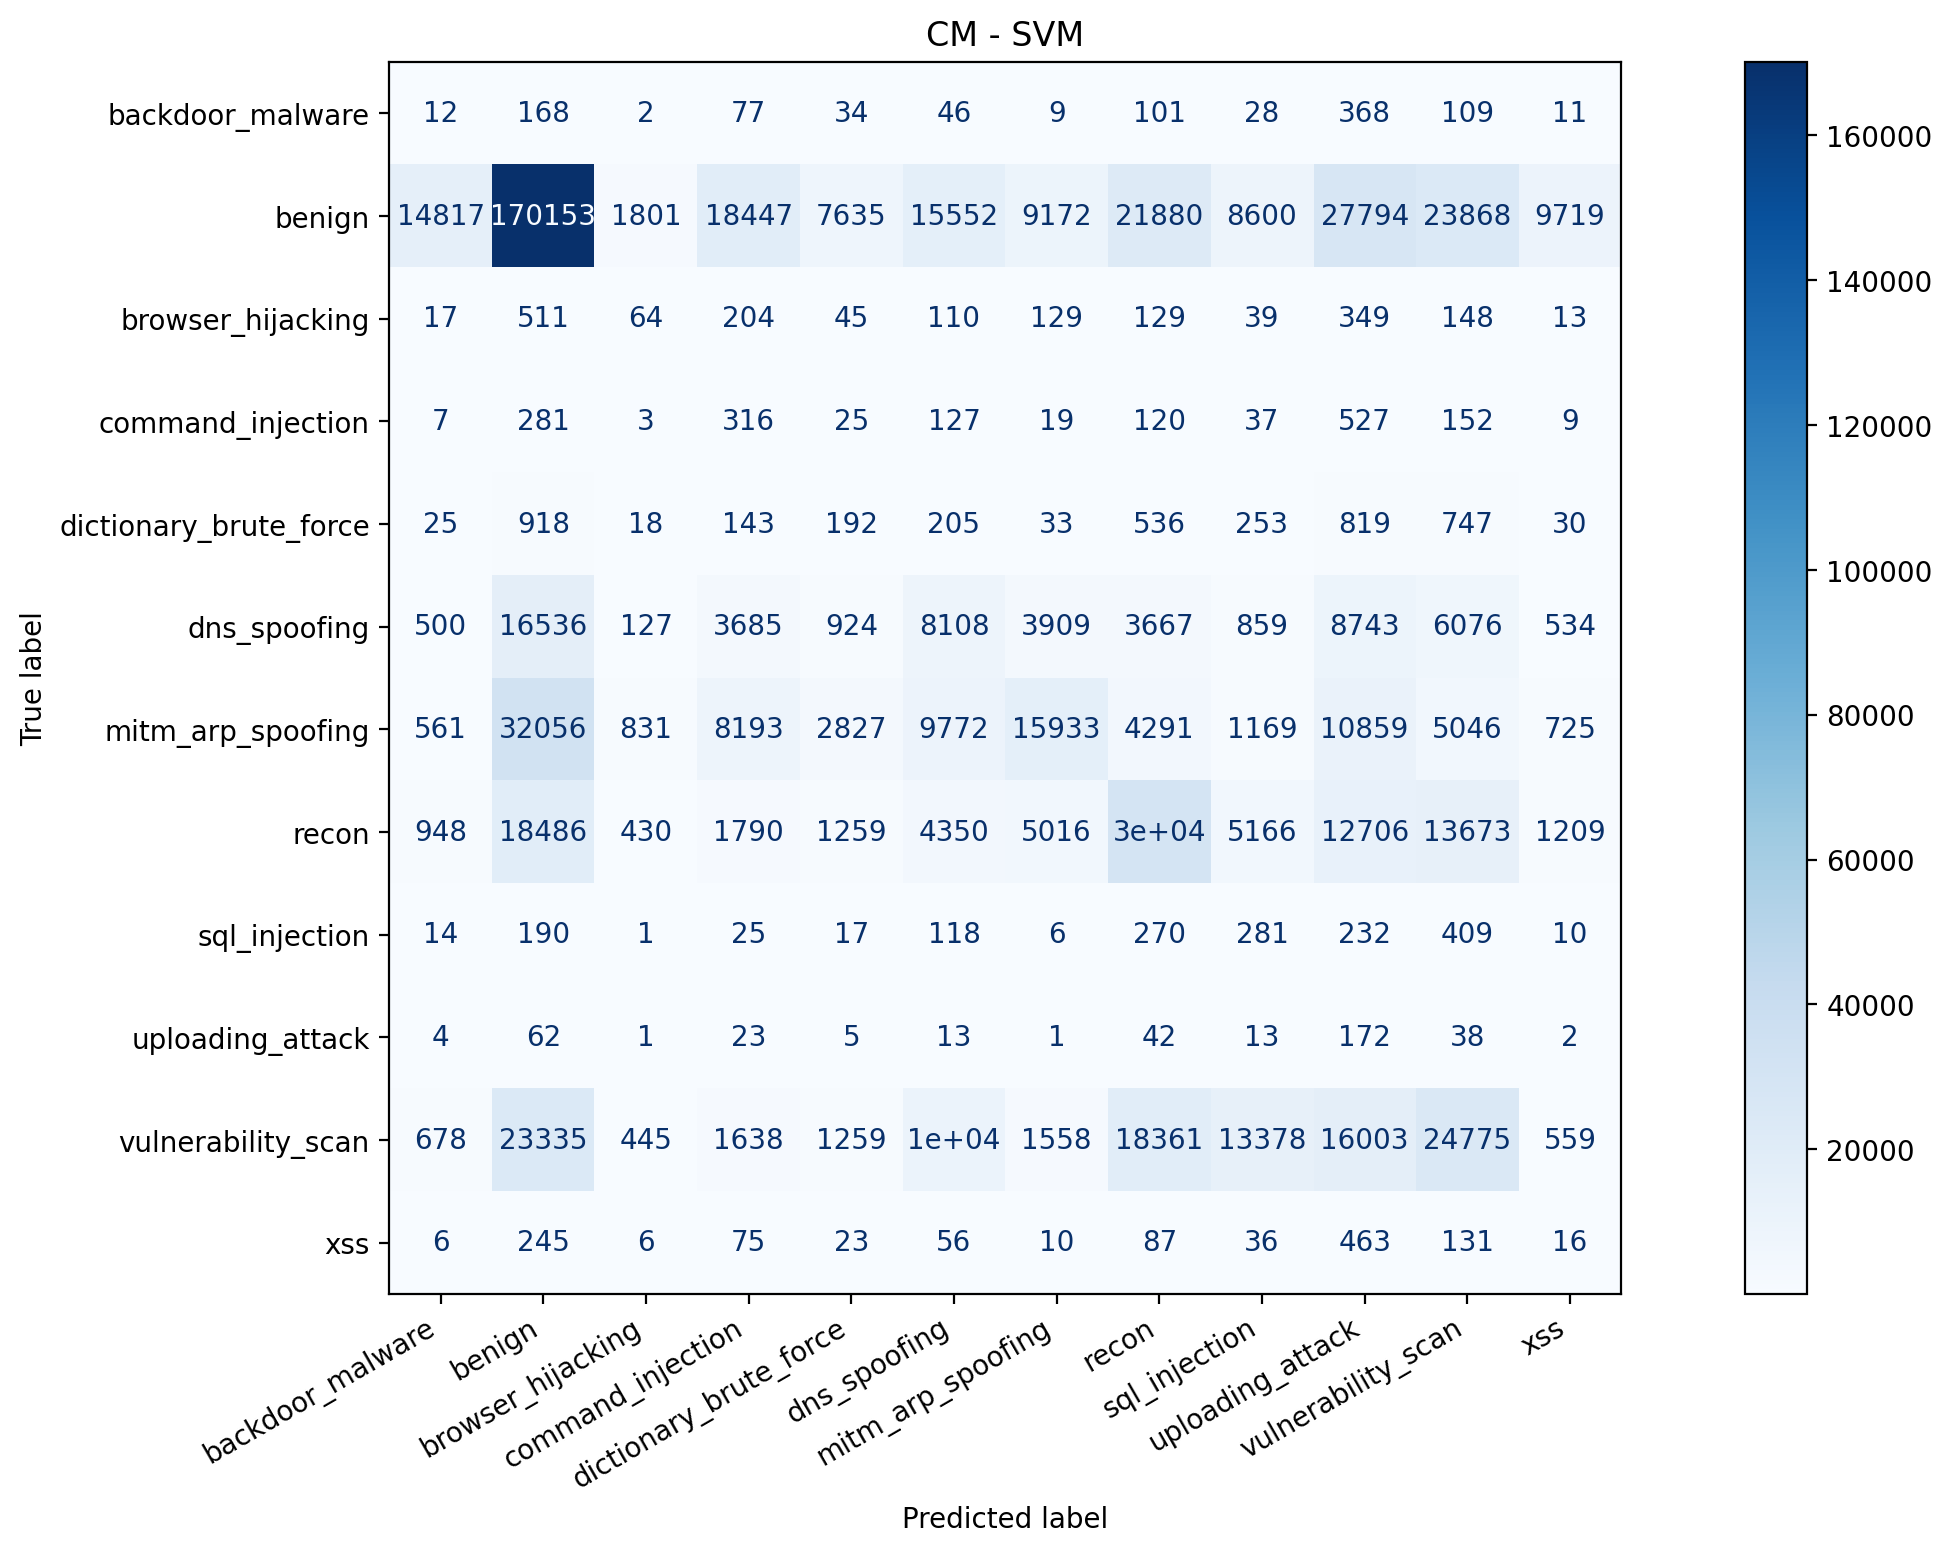

In [69]:
disp = ConfusionMatrixDisplay(confusion_matrix=result_svm['confusion_matrix'], display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(16, 8))
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=30, ha="right")
plt.title('CM - SVM')
plt.show()

### SGDClassifier (hinge loss)

Por que `hinge`?

In [70]:
from sklearn.linear_model import SGDClassifier

In [71]:
model_sgd = SGDClassifier(loss="hinge", class_weight="balanced", random_state=42)
result_sgd = train_model(model_sgd, X_train, X_test, y_train, y_test, target_labels)
results.append(result_sgd)
df_results = pd.DataFrame(results).set_index("model");

In [72]:
joblib.dump(result_sgd, 'models/model_sgd.pkl', compress=3)

['models/model_sgd.pkl']

In [73]:
df_results[['accuracy', 'precision', 'recall', 'f1', 'train_time', 'test_time']]

accuracy  precision  recall   f1  train_time  test_time
model                                                                 
LinearSVC          0.36       0.17    0.19 0.14      871.56       0.34
SGDClassifier      0.24       0.12    0.14 0.08      244.97       0.36

In [74]:
print(classification_report(y_test, result_sgd['predictions']))

                        precision    recall  f1-score   support

      backdoor_malware       0.00      0.00      0.00       965
                benign       0.61      0.33      0.43    329438
     browser_hijacking       0.01      0.05      0.01      1758
     command_injection       0.01      0.02      0.01      1623
dictionary_brute_force       0.00      0.00      0.00      3919
          dns_spoofing       0.12      0.65      0.21     53668
     mitm_arp_spoofing       0.20      0.02      0.04     92263
                 recon       0.18      0.16      0.17     95153
         sql_injection       0.01      0.21      0.01      1573
      uploading_attack       0.00      0.15      0.00       376
    vulnerability_scan       0.25      0.06      0.10    112003
                   xss       0.02      0.07      0.02      1154

              accuracy                           0.24    693893
             macro avg       0.12      0.14      0.08    693893
          weighted avg       0.39     

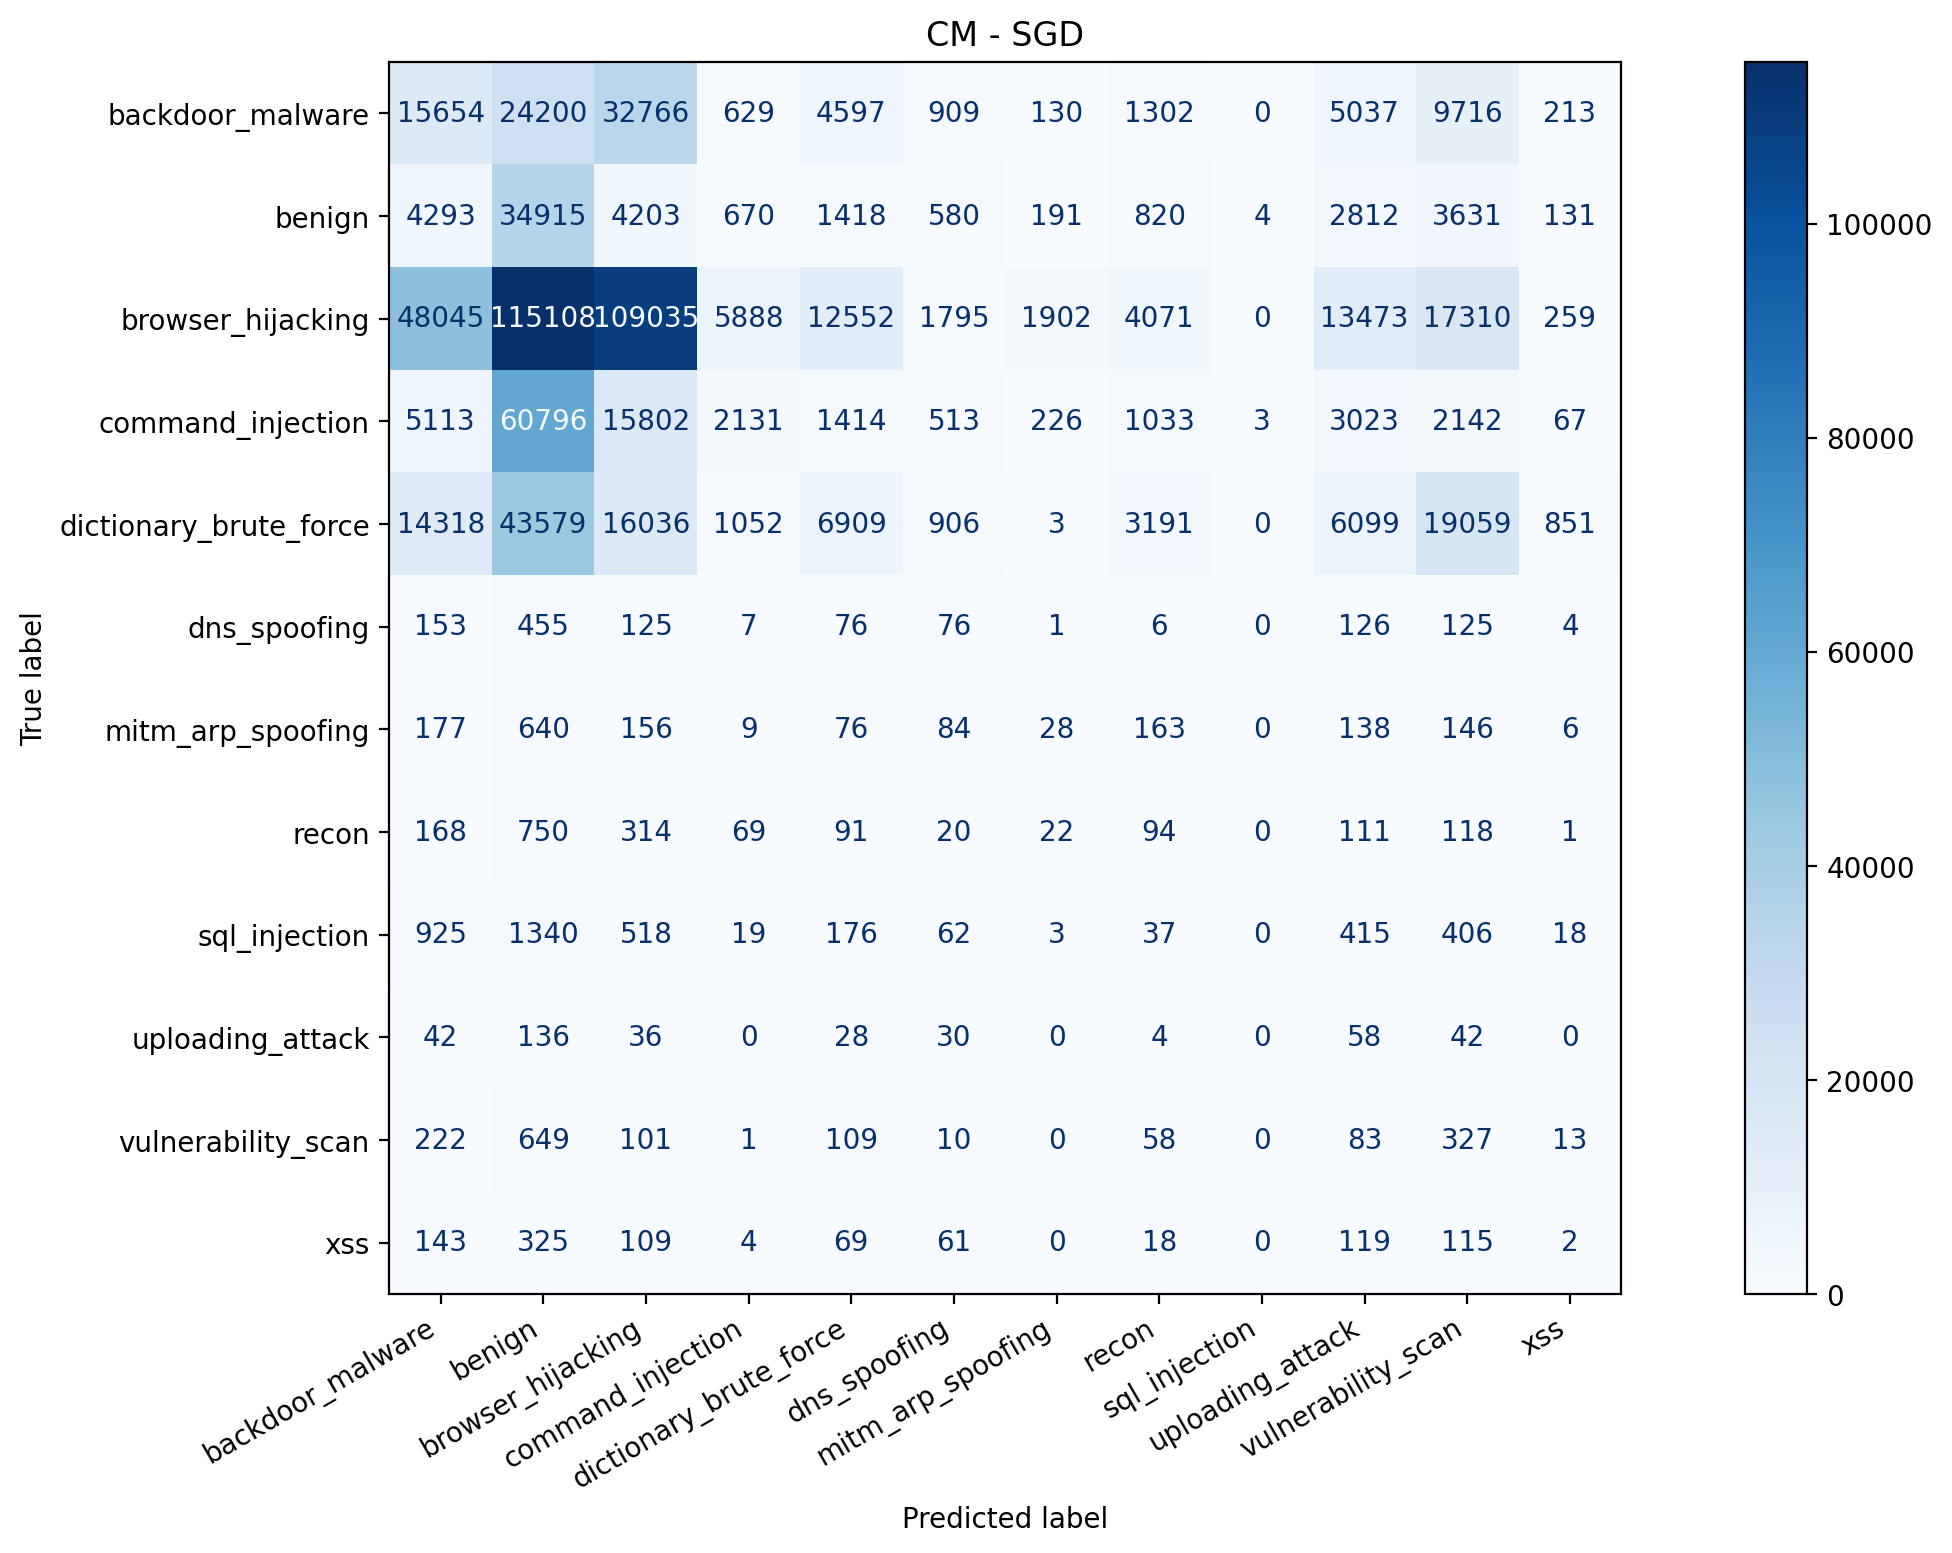

In [75]:
disp = ConfusionMatrixDisplay(confusion_matrix=result_sgd['confusion_matrix'], display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(16, 8))
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=30, ha="right")
plt.title('CM - SGD')
plt.show()

---

## Comparações

In [ ]:
df_results = pd.DataFrame(models).set_index("model");

In [15]:
name_mapping = {
    "LogisticRegression": "Regressão Logística",
    "RandomForestClassifier": "Random Forest",
    "XGBClassifier": "XGBoost",
    "LGBMClassifier": "LightGBM",
    "MLPClassifier": "MLP",
    "TabNetClassifier": "TabNet",
    "LinearSVC": "SVM (Linear)",
    "SGDClassifier": "SGD"
};

In [16]:
df_results = df_results.rename(index=name_mapping);

### Matrizes de Confusão

In [27]:
df_results = pd.read_pickle('df_results.pkl')

accuracy  precision  recall   f1  \
model                                                   
LightGBM                 0.76       0.47    0.37 0.40   
Random Forest            0.77       0.59    0.37 0.41   
Regressão Logística      0.25       0.07    0.12 0.06   
SGD                      0.24       0.12    0.14 0.08   
SVM (Linear)             0.36       0.17    0.19 0.14   
TabNet                   0.72       0.57    0.32 0.35   
XGBoost                  0.77       0.67    0.38 0.43   
MLP                      0.51       0.15    0.11 0.09   

                                                      confusion_matrix  \
model                                                                    
LightGBM             [[80, 353, 3, 36, 1, 3, 56, 93, 1, 12, 307, 20...   
Random Forest        [[50431, 260, 28044, 1118, 15161, 11, 6, 53, 5...   
Regressão Logística  [[0, 13, 10322, 40966, 0, 0, 43852, 0, 0, 0, 0...   
SGD                  [[15654, 24200, 32766, 629, 4597, 909, 130, 13...   
SVM (Linear)         [[12, 168, 2, 77, 34, 46, 9, 101, 28, 368, 109...   
TabNet               [[0, 476, 0, 12, 0, 1, 87, 8, 0, 0, 381, 0], [...   
XGBoost              [[75, 362, 0, 30, 0, 5, 56, 105, 1, 1, 314, 16...   
MLP                  [[0, 754, 0, 0, 0, 0, 0, 0, 0, 0, 211, 0], [0,...   

                                                           predictions  \
model                                                                    
LightGBM             [1, 10, 1, 10, 10, 10, 1, 1, 7, 1, 7, 1, 1, 1,...   
Random Forest        [benign, vulnerability_scan, benign, vulnerabi...   
Regressão Logística  [command_injection, command_injection, mitm_ar...   
SGD                  [recon, vulnerability_scan, dns_spoofing, dns_...   
SVM (Linear)         [9, 8, 1, 7, 10, 8, 10, 9, 9, 5, 7, 1, 1, 3, 1...   
TabNet               [10, 10, 1, 10, 10, 10, 1, 10, 7, 1, 7, 1, 1, ...   
XGBoost              [1, 10, 1, 10, 10, 10, 1, 10, 7, 1, 7, 1, 1, 1...   
MLP                  [1, 10, 1, 1, 10, 10, 1, 1, 10, 1, 10, 1, 1, 1...   

                     train_time  test_time  
model                                       
LightGBM                  55.14      10.11  
Random Forest            318.24      23.48  
Regressão Logística      539.10       0.35  
SGD                      244.97       0.36  
SVM (Linear)             871.56       0.34  
TabNet                 4,285.87       7.79  
XGBoost                  102.97       3.05  
MLP                      225.97       7.21

In [28]:
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

{0: 'backdoor_malware',
 1: 'benign',
 2: 'browser_hijacking',
 3: 'command_injection',
 4: 'dictionary_brute_force',
 5: 'dns_spoofing',
 6: 'mitm_arp_spoofing',
 7: 'recon',
 8: 'sql_injection',
 9: 'uploading_attack',
 10: 'vulnerability_scan',
 11: 'xss'}

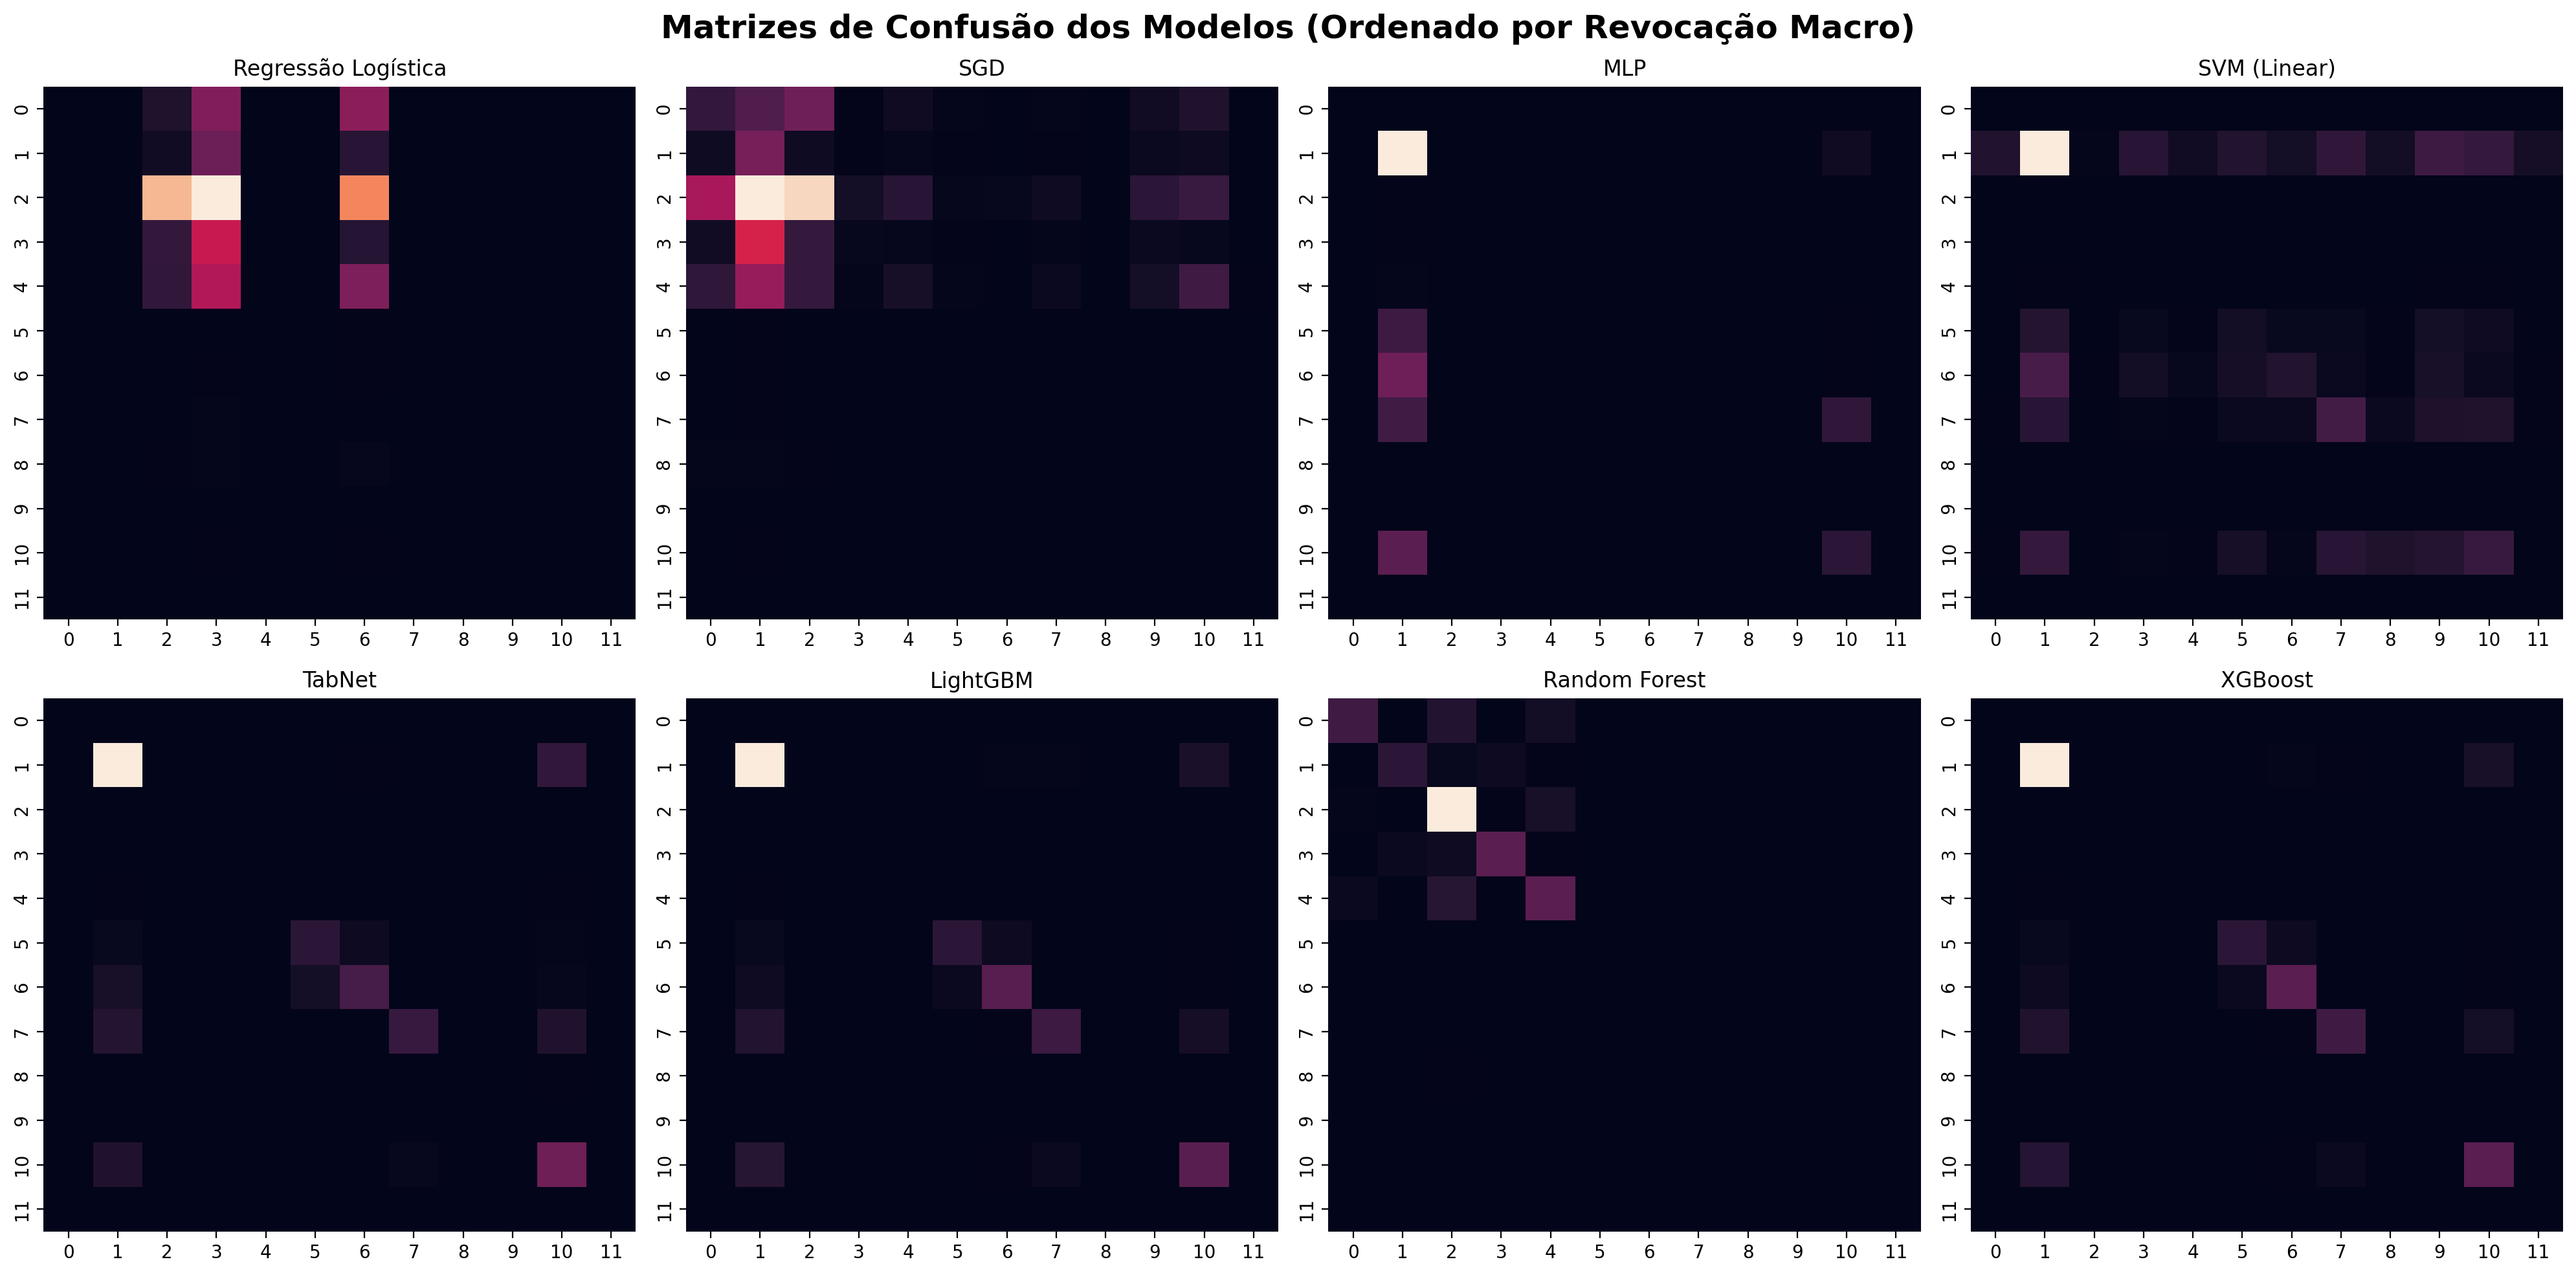

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, model in enumerate(df_results.sort_values(by="f1").index):
    cm = df_results.loc[model, "confusion_matrix"]
    sns.heatmap(cm, fmt="d", ax=axes[i], cbar=False)
    axes[i].set_title(model)
plt.suptitle('Matrizes de Confusão dos Modelos (Ordenado por Revocação Macro)', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

### Métricas

In [30]:
df_results[["accuracy", "precision", "recall", "f1", "train_time", "test_time"]].sort_values(ascending=True, by='recall')

accuracy  precision  recall   f1  train_time  test_time
model                                                                       
MLP                      0.51       0.15    0.11 0.09      225.97       7.21
Regressão Logística      0.25       0.07    0.12 0.06      539.10       0.35
SGD                      0.24       0.12    0.14 0.08      244.97       0.36
SVM (Linear)             0.36       0.17    0.19 0.14      871.56       0.34
TabNet                   0.72       0.57    0.32 0.35    4,285.87       7.79
LightGBM                 0.76       0.47    0.37 0.40       55.14      10.11
Random Forest            0.77       0.59    0.37 0.41      318.24      23.48
XGBoost                  0.77       0.67    0.38 0.43      102.97       3.05

### Plot Métricas Globais

In [31]:
import os
import joblib
models = []
model_dir = './models'
for filename in sorted(os.listdir(model_dir)):
    if filename == 'model_rf.pkl':  # Ignora o random forest
        continue
    filepath = os.path.join(model_dir, filename)
    try:
        model = joblib.load(filepath)
        models.append(model)
        print(f'Modelo {filename} carregado com sucesso.')
    except Exception as e:
        print(f'Erro ao carregar {filename}: {e}')

Erro ao carregar .ipynb_checkpoints: [Errno 21] Is a directory: './models/.ipynb_checkpoints'
Modelo model_lgbm.pkl carregado com sucesso.
Modelo model_logreg.pkl carregado com sucesso.
Modelo model_mlp.pkl carregado com sucesso.
Modelo model_sgd.pkl carregado com sucesso.
Modelo model_svm.pkl carregado com sucesso.
Modelo model_tabnet.pkl carregado com sucesso.
Modelo model_xgb.pkl carregado com sucesso.


In [32]:
models.append(result_rf)

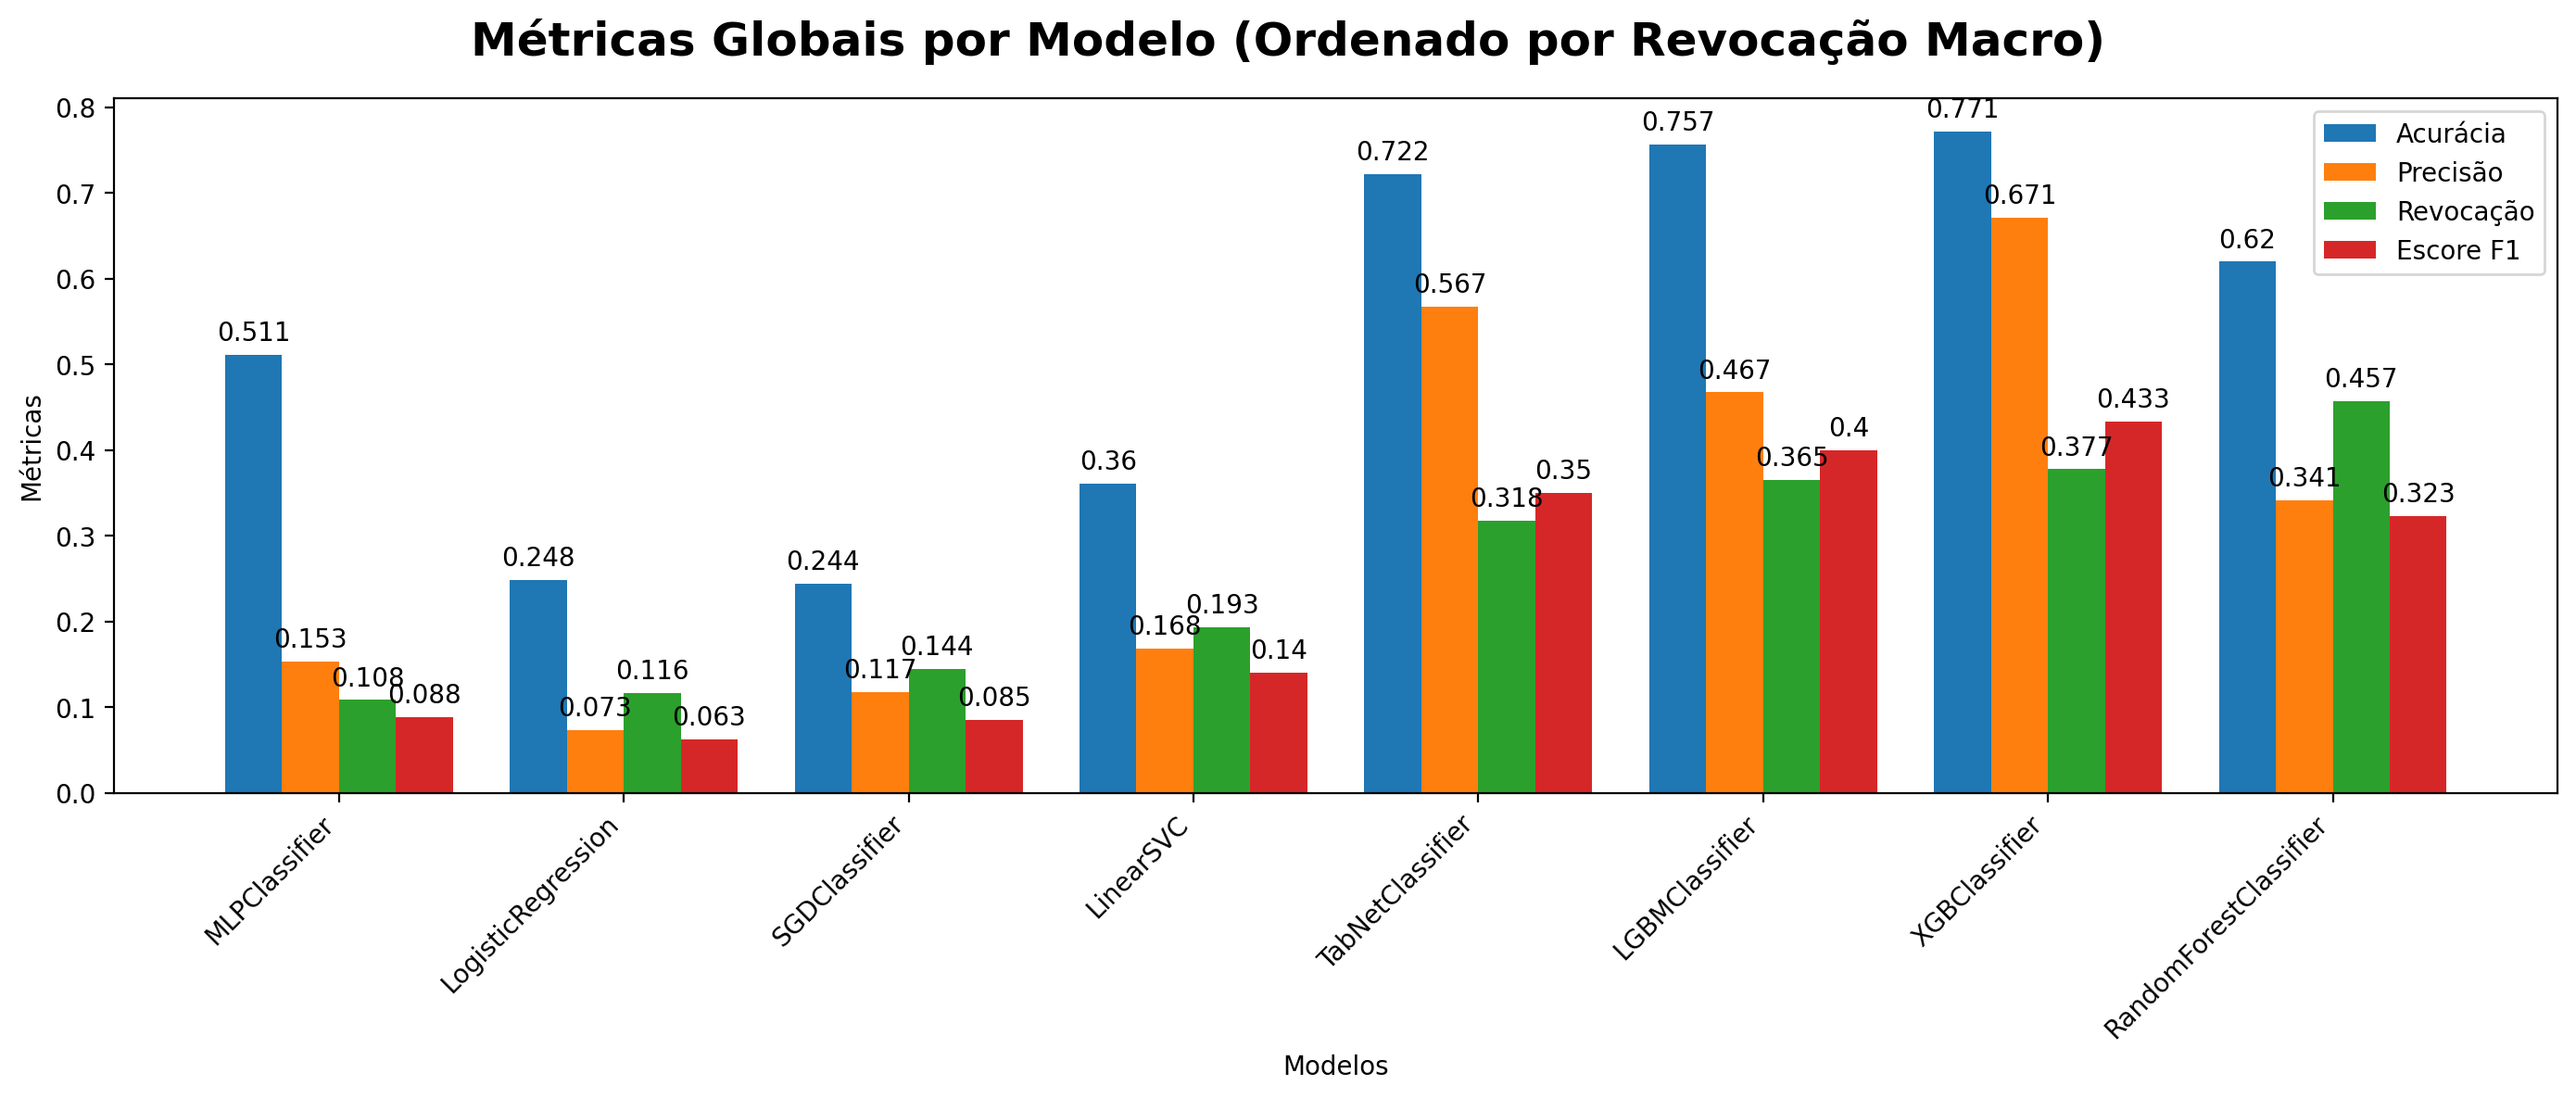

In [33]:
# ordenar pelo recall
models_sorted = sorted(models, key=lambda x: x['recall'])

model_names      = [model['model'] for model in models_sorted]
accuracy_values  = [model['accuracy'] for model in models_sorted]
precision_values = [model['precision'] for model in models_sorted]
recall_values    = [model['recall'] for model in models_sorted]
f1_values        = [model['f1'] for model in models_sorted]

bar_width = 0.2
index = np.arange(len(models_sorted))

fig, ax = plt.subplots(figsize=(14, 6))

bar1 = ax.bar(index, accuracy_values, bar_width, label='Acurácia')
bar2 = ax.bar(index + bar_width, precision_values, bar_width, label='Precisão')
bar3 = ax.bar(index + 2 * bar_width, recall_values, bar_width, label='Revocação')
bar4 = ax.bar(index + 3 * bar_width, f1_values, bar_width, label='Escore F1')

ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_xlabel('Modelos')
ax.set_ylabel('Métricas')
ax.legend()

# Adicionando os valores perto das barras
for i in range(len(models_sorted)):
    ax.text(bar1[i].get_x() + bar1[i].get_width() / 2, bar1[i].get_height() + 0.01, 
            round(accuracy_values[i], 3), ha='center', va='bottom')
    ax.text(bar2[i].get_x() + bar2[i].get_width() / 2, bar2[i].get_height() + 0.01, 
            round(precision_values[i], 3), ha='center', va='bottom')
    ax.text(bar3[i].get_x() + bar3[i].get_width() / 2, bar3[i].get_height() + 0.01, 
            round(recall_values[i], 3), ha='center', va='bottom')
    ax.text(bar4[i].get_x() + bar4[i].get_width() / 2, bar4[i].get_height() + 0.01, 
            round(f1_values[i], 3), ha='center', va='bottom')

plt.suptitle('Métricas Globais por Modelo (Ordenado por Revocação Macro)', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

### Plot Métricas por Classe

In [34]:
# Calculate per-class metrics for each model
metrics_by_model_class = {}

for model_idx, model_dict in enumerate(models):
    model_name = model_dict['model']
    predictions = model_dict['predictions']
    
    y_true = y_test.values if hasattr(y_test, 'values') else y_test
    
    if isinstance(predictions[0], (int, np.integer)):
        y_pred = np.array([label_mapping[p] for p in predictions])
    else:
        y_pred = predictions
        
    y_true_enc = np.array([list(label_mapping.values()).index(c) for c in y_true])
    y_pred_enc = np.array([list(label_mapping.values()).index(c) for c in y_pred])
        
    class_metrics = {}
    
    for class_idx, class_name in label_mapping.items():
        true_positives = sum((y_true_enc == class_idx) & (y_pred_enc == class_idx))
        false_positives = sum((y_true_enc != class_idx) & (y_pred_enc == class_idx))
        false_negatives = sum((y_true_enc == class_idx) & (y_pred_enc != class_idx))
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        class_metrics[class_name] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    metrics_by_model_class[model_name] = class_metrics

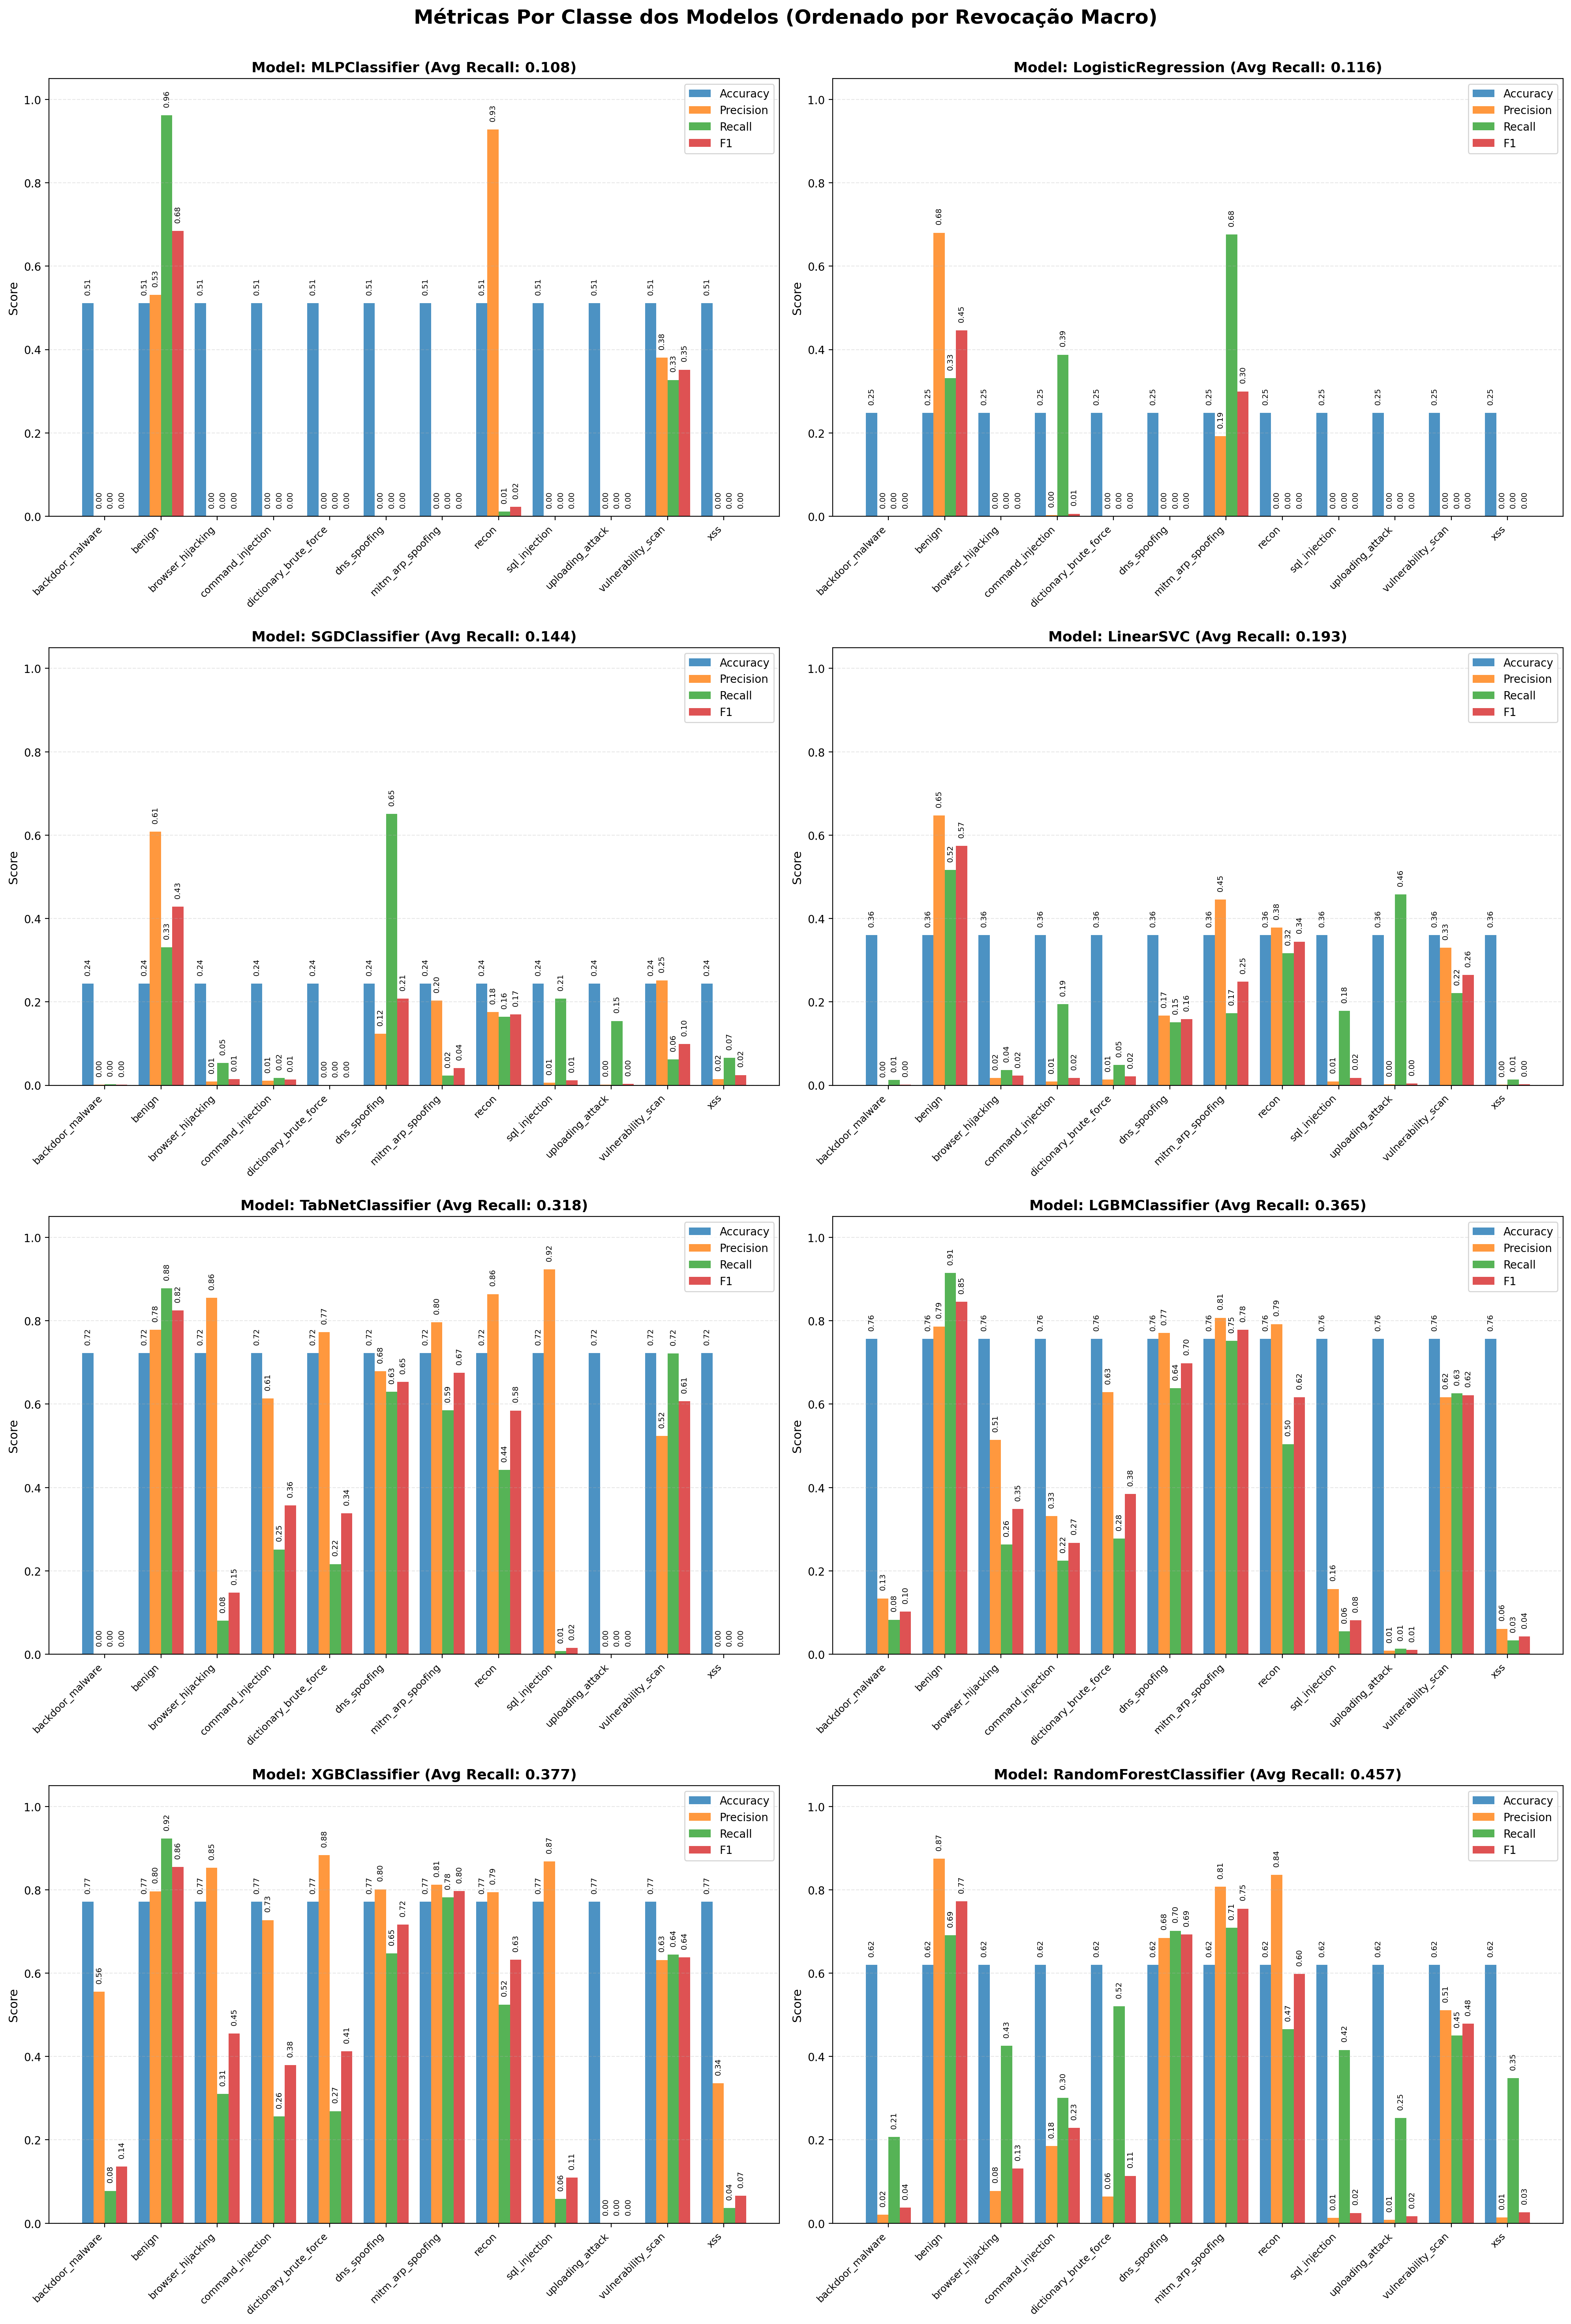

In [36]:
# Collect metrics for each model
model_avg_recalls = []
for model_dict in models:
    model_name = model_dict['model']
    recalls = [metrics_by_model_class[model_name][class_name]['recall'] for class_name in label_mapping.values()]
    avg_recall = np.mean(recalls)
    model_avg_recalls.append((model_name, avg_recall))

# Sort models by average recall
sorted_models = [name for name, _ in sorted(model_avg_recalls, key=lambda x: x[1])]

# Create one plot per model with 2 plots per row
n_rows = (len(models) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(20, 5*1.5*n_rows))
axes = axes.flatten()

class_names = list(label_mapping.values())
metrics = ['accuracy', 'precision', 'recall', 'f1']

bar_width = 0.2
index = np.arange(len(class_names))

for i, model_name in enumerate(sorted_models):
    ax = axes[i]
    model_dict = next(m for m in models if m['model'] == model_name)
    
    # For each class, plot the 4 metrics
    for j, metric in enumerate(metrics):
        values = []
        for class_name in class_names:
            if metric == 'accuracy':
                values.append(model_dict[metric])
            else:
                values.append(metrics_by_model_class[model_name][class_name][metric])
        
        bars = ax.bar(index + j * bar_width, values, bar_width, 
                     label=metric.capitalize(), alpha=0.8)
        
        # Add values on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=7, rotation=90)
    
    # Set x-axis labels
    ax.set_xticks(index + bar_width * 1.5)
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
    
    # Set title and labels
    avg_recall = next(recall for name, recall in model_avg_recalls if name == model_name)
    ax.set_title(f'Model: {model_name} (Avg Recall: {avg_recall:.3f})', fontsize=13, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11)
    ax.set_ylim(0, 1.05)
    
    # Add grid for readability
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add legend to all plots
    ax.legend(loc='upper right', fontsize=10)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3)
plt.suptitle('Métricas Por Classe dos Modelos (Ordenado por Revocação Macro)', fontsize=18, fontweight='bold')
plt.show()

---

## Próximos Passos

- Feature Importance
    - https://mariofilho.com/feature-importance-random-forests/
    - https://mariofilho.com/xgboost-classificacao-multiclasse-python/
- Explicações
    - LIME
    - SHAP

---

## Fim